# Import libraries

In [1]:
# Basic
import pandas as pd
import numpy as np
import os
from platform import python_version

# mlflow
import mlflow
from urllib.parse import urlparse
import mlflow.sklearn
import mlflow.xgboost
from random import random, randint
from mlflow import log_metric, log_param, log_artifacts

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mso

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model selection
from sklearn.model_selection import train_test_split

# Auto ML
#from tpot import TPOTClassifier

# Modeling
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Feature importance (XGBoost)
from xgboost import plot_importance

# Report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, \
    confusion_matrix, classification_report

# Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.svm import SVC

# Pipeline
from imblearn.pipeline import Pipeline
#preprocessing pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#import warnings
#warnings.filterwarnings("ignore")

# Database

In [89]:
df = pd.read_csv("data/bquxjob_4a55ecd5_184c3af4fbe.csv")
df

,fullVisitorId,bounces,time_on_site,will_buy_on_return_visit,pageviews,medium,channelGrouping,deviceCategory,country,date
0,5777438125314310020,0,12884,0,169.0,organic,Organic Search,desktop,United States,20220919
1,5777438125314310020,0,12884,0,1.0,organic,Organic Search,desktop,United States,20220919
2,5777438125314310020,0,12884,0,8.0,organic,Organic Search,desktop,United States,20220919
3,5777438125314310020,0,12884,1,178.0,organic,Organic Search,desktop,United States,20220919
4,7209403264301039802,0,8793,0,1.0,(none),Direct,desktop,United States,20220928
...,...,...,...,...,...,...,...,...,...,...
48049,4362490200806308515,1,0,0,1.0,(none),Direct,desktop,(not set),20220924
48050,6737381346243471980,1,0,0,1.0,(none),Direct,desktop,(not set),20220924
48051,3763043934585916260,1,0,0,1.0,(none),Direct,desktop,(not set),20220924
48052,1512694728925216829,1,0,0,1.0,(none),Direct,desktop,United States,20220926


# EDA

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48054 entries, 0 to 48053
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fullVisitorId             48054 non-null  uint64 
 1   bounces                   48054 non-null  int64  
 2   time_on_site              48054 non-null  int64  
 3   will_buy_on_return_visit  48054 non-null  int64  
 4   pageviews                 47841 non-null  float64
 5   medium                    48054 non-null  object 
 6   channelGrouping           48054 non-null  object 
 7   deviceCategory            48054 non-null  object 
 8   country                   48054 non-null  object 
 9   date                      48054 non-null  int64  
dtypes: float64(1), int64(4), object(4), uint64(1)
memory usage: 3.7+ MB


In [91]:
df.duplicated().sum()

0

<br>
<b>48903</b> ligne et <b>9</b> colonne. Il s'agit d'un échantillon de données exporté de Big Query.  

<ul><li><b>fullvisitorid</b> : Identification des visiteurs, avec un unique ID.</li>
<br>
<li><b>bounce</b> : Le taux de rebond. Nous calculons le bounce grâce à la fonction native totals.bounces .</li>
<br>
<li><b>time_on_site</b> : Pareil que pour bounces, Big Query va chercher la donnée dans la fonction native totals.timeOnSite . La durée ici est en seconde.</li>
<br>
<li><b>will_buy_on_return_visit</b> : Notre target. Elle est créée grâce aux dimensions de Google Analytics “transactions” et “newVisits”. Si les transactions sont inférieures à 0 ET que l’information nouvelle visite est NULL, la target retourne le bon résultat. Donc, selon les transactions et si les utilisateurs sont des nouveaux visiteurs ou non, le modèle classifie par 1 (l’utilisateur achètera lors de sa prochaine visite) ou par 0 (l’utilisateur n'achètera pas lors de sa prochaine visite).</li>
<br>
    <li><b>pageviews</b> : Il s’agit d’une dimension de Google Analytics. GA possède sa propre définition d'une pageview :  
    Le pageview (ou pageview hit, page tracking hit) est une instance d'une page en cours de chargement (ou de rechargement) dans un navigateur. Elles sont une mesure définie comme le nombre total de pages consultées. Les vues répétées d'une seule page sont comptées.</li>
<br>
<li><i><b>Source</b> et <b>Medium</b> sont des outils importants dans Google Analytics, car ils nous indiquent non seulement comment les internautes interagissent avec notre site Web, mais également d'où ils viennent. Cette section de GA décompose cela en nous montrant les liens entrants, de quels types de liens il s'agit et quels sites renvoient vers le nôtre. Ici, ils sont indiqués par les deux noms suivants :</i></li>
<br>
<li><b>medium</b> : Ce sont de larges ensembles de catégories qui décrivent le type  de trafic généré vers notre site Web. Par exemple, "Organic" est un medium car il englobe le trafic provenant de moteurs de recherche tels que Google. "Referral", "Social" et "Paid" sont d'autres exemples de medium.</li>
<br>
        <li><b>channelGrouping</b> : Les sources sont les domaines réels qui envoient du trafic vers notre site Web. Google Analytics les remplira automatiquement ou nous pouvons les modifier pour des URL de campagne spécifiques à l'aide du balisage UTM. Dans le cas d'un trafic "Organic", la source serait "Google". Pour le trafic “Referral”, la source peut être nytimes.com. Pour le trafic "Social", la source pourrait être facebook.com… .</li>
<br>
<li><b>deviceCategory</b> : Il permet de savoir quel type de support les utilisateurs utilisent-ils pour naviguer sur notre site web. (Desktop, Mobile etc… )</li>
<br>
<li><b>country</b> : Il s’agit d’une dimension dans Google Analytics, sous la section Geo Network, qui permet d’avoir le pays des utilisateurs, dérivé de leurs adresses IP ou de leurs identifiants géographiques.</li>  
<br>
<li><b>date</b> : Jour, mois et année de la session.</li>  
</ul>

## Etude de la target et de la forme des données

In [92]:
df['will_buy_on_return_visit'].value_counts() #target déséquilibrée

0    43911
1     4143
Name: will_buy_on_return_visit, dtype: int64

In [93]:
df.isnull().sum() #valeurs manquantes

fullVisitorId                 0
bounces                       0
time_on_site                  0
will_buy_on_return_visit      0
pageviews                   213
medium                        0
channelGrouping               0
deviceCategory                0
country                       0
date                          0
dtype: int64

In [94]:
df[df['pageviews'].isnull()]['will_buy_on_return_visit']

780      0
1745     0
2032     0
2170     0
2378     0
        ..
46289    0
46972    0
47448    0
47496    0
47955    0
Name: will_buy_on_return_visit, Length: 213, dtype: int64

In [95]:
#Certaines sessions ne sont pas uniques. Il peut s'agir d'un même utilisateur revenant sur le site web

df['fullVisitorId'].unique

<bound method Series.unique of 0        5777438125314310020
1        5777438125314310020
2        5777438125314310020
3        5777438125314310020
4        7209403264301039802
                ...         
48049    4362490200806308515
48050    6737381346243471980
48051    3763043934585916260
48052    1512694728925216829
48053    2625321494606109308
Name: fullVisitorId, Length: 48054, dtype: uint64>

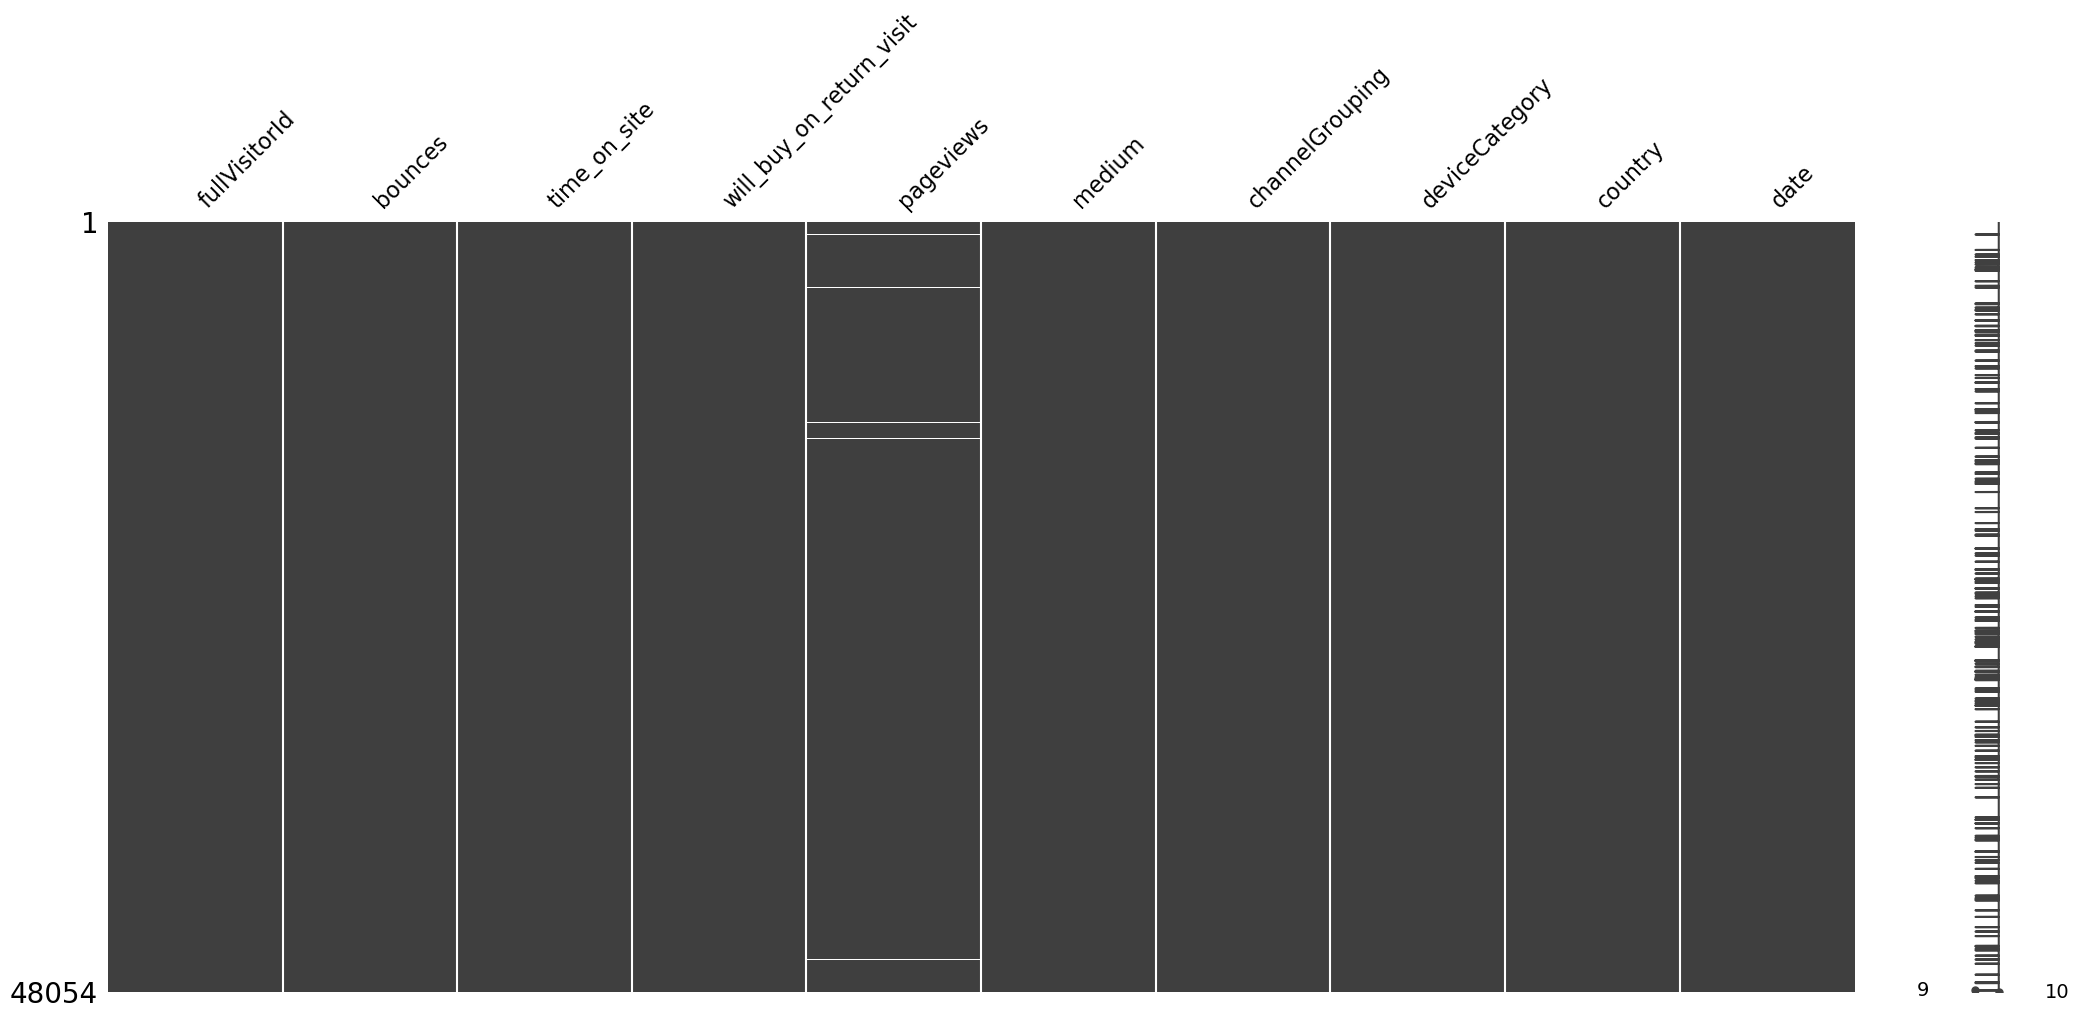

In [96]:
mso.matrix(df)
plt.show()

La librairie missingno permet de mieux voir les valeurs manquantes. Elle permet aussi de voir si les valeurs manquantes sont corrélées ou non entre elles.  
Dans notre cas, les valeurs manquantes se trouvent exclusivement sur pageviews et ne sont pas suffisamment nombreux pour impacter notre futur modèle.   

In [97]:
#Je change l'index en transposant la colonne fullVisitorID pour ne pas la perdre, 
#car la colonne n'apportera rien au modèle.
df = df.set_index('fullVisitorId')
df

,bounces,time_on_site,will_buy_on_return_visit,pageviews,medium,channelGrouping,deviceCategory,country,date
fullVisitorId,,,,,,,,,
5777438125314310020,0,12884,0,169.0,organic,Organic Search,desktop,United States,20220919
5777438125314310020,0,12884,0,1.0,organic,Organic Search,desktop,United States,20220919
5777438125314310020,0,12884,0,8.0,organic,Organic Search,desktop,United States,20220919
5777438125314310020,0,12884,1,178.0,organic,Organic Search,desktop,United States,20220919
7209403264301039802,0,8793,0,1.0,(none),Direct,desktop,United States,20220928
...,...,...,...,...,...,...,...,...,...
4362490200806308515,1,0,0,1.0,(none),Direct,desktop,(not set),20220924
6737381346243471980,1,0,0,1.0,(none),Direct,desktop,(not set),20220924
3763043934585916260,1,0,0,1.0,(none),Direct,desktop,(not set),20220924


## Data Visualisation

In [98]:
for i in df.columns:
    print(df[i].value_counts())
    print('-----------------------------')

0    31500
1    16554
Name: bounces, dtype: int64
-----------------------------
0       16641
7         187
8         180
13        170
14        157
        ...  
1880        1
1882        1
1588        1
2479        1
1026        1
Name: time_on_site, Length: 2381, dtype: int64
-----------------------------
0    43911
1     4143
Name: will_buy_on_return_visit, dtype: int64
-----------------------------
1.0      18830
3.0       3438
2.0       3223
4.0       2840
5.0       2309
         ...  
139.0        1
121.0        1
80.0         1
331.0        1
105.0        1
Name: pageviews, Length: 117, dtype: int64
-----------------------------
(none)       29908
organic      13479
referral      3602
email          662
Email          227
(not set)      110
cpc             29
banner          21
app             15
cpm              1
Name: medium, dtype: int64
-----------------------------
Direct            29908
Organic Search    13479
Referral           3599
Email               662
(Other)    

### Choix des colonnes

In [99]:
print(df['medium'].value_counts())
print('----------------------------')
print(df['channelGrouping'].value_counts())
print('----------------------------')
print(df['deviceCategory'].value_counts())

(none)       29908
organic      13479
referral      3602
email          662
Email          227
(not set)      110
cpc             29
banner          21
app             15
cpm              1
Name: medium, dtype: int64
----------------------------
Direct            29908
Organic Search    13479
Referral           3599
Email               662
(Other)             352
Paid Search          29
Display              22
Social                3
Name: channelGrouping, dtype: int64
----------------------------
desktop    44949
mobile      2811
tablet       294
Name: deviceCategory, dtype: int64


Les informations de medium et de channelGrouping sont assez similaires. Je décide de garder celle qui me paraît plus intéressante pour le modèle afin d'éviter de le tromper avec des informations doublons. ChannelGrouping semble être la mieux à encoder pour éviter le problème des poids.  

Je retire également les dates puisque nous ne sommes pas dans une problématique de timeline.  

En faisant un "df['country'].value_counts(ascending=False)" , j'ai pu voir les pays ayant le plus de visite sur le site web, ceux au dessus ou très proche de 50 visites. J'ai décidé de ne garder que ces principaux pays afin d'éviter les mêmes problèmes de poids avec l'encodage de la donnée.  


In [100]:
df_country = df.copy()[df["country"].isin(["United States","France", "(not set)", 
                                           "Finland", "India", "China", "United Kingdom",
                                           "Russia", "Canada", "Germany", "Netherlands"])]
df_country['country'].value_counts(ascending=False)

United States     37584
(not set)          9004
India               233
Canada              137
Netherlands         115
Germany             111
France               93
Russia               75
China                58
Finland              49
United Kingdom       47
Name: country, dtype: int64

In [101]:
df_country

,bounces,time_on_site,will_buy_on_return_visit,pageviews,medium,channelGrouping,deviceCategory,country,date
fullVisitorId,,,,,,,,,
5777438125314310020,0,12884,0,169.0,organic,Organic Search,desktop,United States,20220919
5777438125314310020,0,12884,0,1.0,organic,Organic Search,desktop,United States,20220919
5777438125314310020,0,12884,0,8.0,organic,Organic Search,desktop,United States,20220919
5777438125314310020,0,12884,1,178.0,organic,Organic Search,desktop,United States,20220919
7209403264301039802,0,8793,0,1.0,(none),Direct,desktop,United States,20220928
...,...,...,...,...,...,...,...,...,...
4362490200806308515,1,0,0,1.0,(none),Direct,desktop,(not set),20220924
6737381346243471980,1,0,0,1.0,(none),Direct,desktop,(not set),20220924
3763043934585916260,1,0,0,1.0,(none),Direct,desktop,(not set),20220924


### Country

In [102]:
df_countries = df.copy()[df["country"].isin(["France","Finland", "India", "China", "United Kingdom",
                                           "Russia", "Canada", "Germany", "Netherlands"])]
df_countries['country'].value_counts(ascending=False)

India             233
Canada            137
Netherlands       115
Germany           111
France             93
Russia             75
China              58
Finland            49
United Kingdom     47
Name: country, dtype: int64

In [103]:
df_countries['country'].value_counts(ascending=False).index

Index(['India', 'Canada', 'Netherlands', 'Germany', 'France', 'Russia',
       'China', 'Finland', 'United Kingdom'],
      dtype='object')

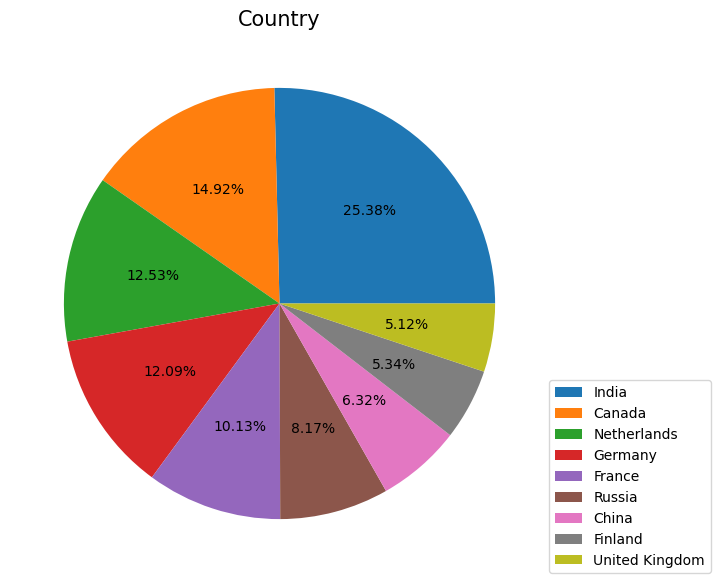

In [104]:
plt.figure(figsize=(10,7))

plt.pie(df_countries['country'].value_counts(ascending=False), autopct='%0.02f%%')

plt.legend(df_countries['country'].value_counts(ascending=False).index, loc=(1,0))
plt.title('Country', fontsize=15)
plt.show()

In [105]:
df_country_usa = df.copy()[df["country"].isin(["United States", "(not set)"])]
df_country_usa['country'].value_counts(ascending=False)

United States    37584
(not set)         9004
Name: country, dtype: int64

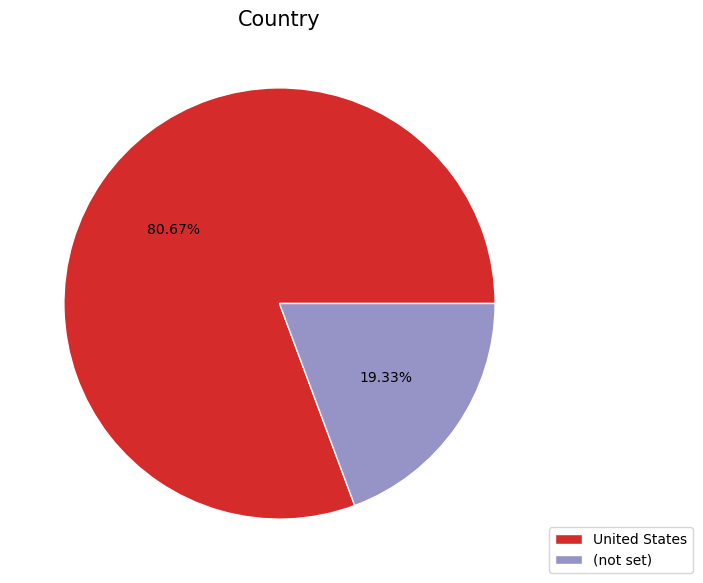

In [106]:
plt.figure(figsize=(10,7))

colors = ['#D52B2B', '#9694C6']

plt.pie(df_country_usa['country'].value_counts(), autopct='%0.02f%%',
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors)

plt.legend(df_country_usa['country'].unique(), loc=(1,0))
plt.title('Country', fontsize=15)
plt.show()

Toutefois, en observant mieux la donnée dans country, "not set" est une donnée trop important qui ne nous apporte pas vraiment de réponse car il s'agit d'une donnée propre à BigQuery. Ce sont les visiteurs dont le pays n'est pas renseigné. Pour notre modèle il est inutile de l'encombrer de cette information et je vais réduire son champ sur les pays dépassant 10% de la donnée.  

In [107]:
df_best_country = df.copy()[df["country"].isin(["United States", "France", 
                                                "India", "China", "Germany",
                                                "Canada", "(not set)"])]
df_best_country['country'].value_counts(ascending=False)

United States    37584
(not set)         9004
India              233
Canada             137
Germany            111
France              93
China               58
Name: country, dtype: int64

In [108]:
df_best_country = df_best_country.drop(['medium','date'], axis= 1)
df_best_country

,bounces,time_on_site,will_buy_on_return_visit,pageviews,channelGrouping,deviceCategory,country
fullVisitorId,,,,,,,
5777438125314310020,0,12884,0,169.0,Organic Search,desktop,United States
5777438125314310020,0,12884,0,1.0,Organic Search,desktop,United States
5777438125314310020,0,12884,0,8.0,Organic Search,desktop,United States
5777438125314310020,0,12884,1,178.0,Organic Search,desktop,United States
7209403264301039802,0,8793,0,1.0,Direct,desktop,United States
...,...,...,...,...,...,...,...
4362490200806308515,1,0,0,1.0,Direct,desktop,(not set)
6737381346243471980,1,0,0,1.0,Direct,desktop,(not set)
3763043934585916260,1,0,0,1.0,Direct,desktop,(not set)


In [109]:
df_visu = df_best_country.copy()

### Categorial data

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


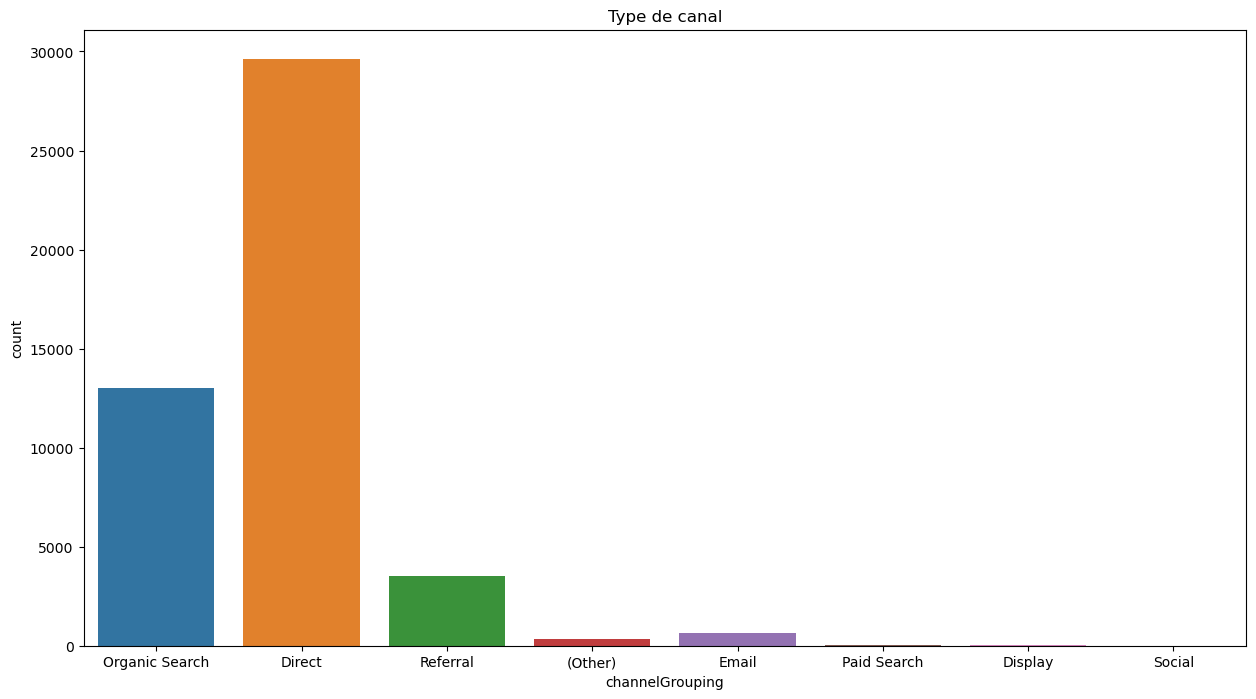

In [110]:
plt.figure(figsize=(15,8))
sns.countplot(df_visu['channelGrouping'])
plt.title(label='Type de canal')
plt.show()

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


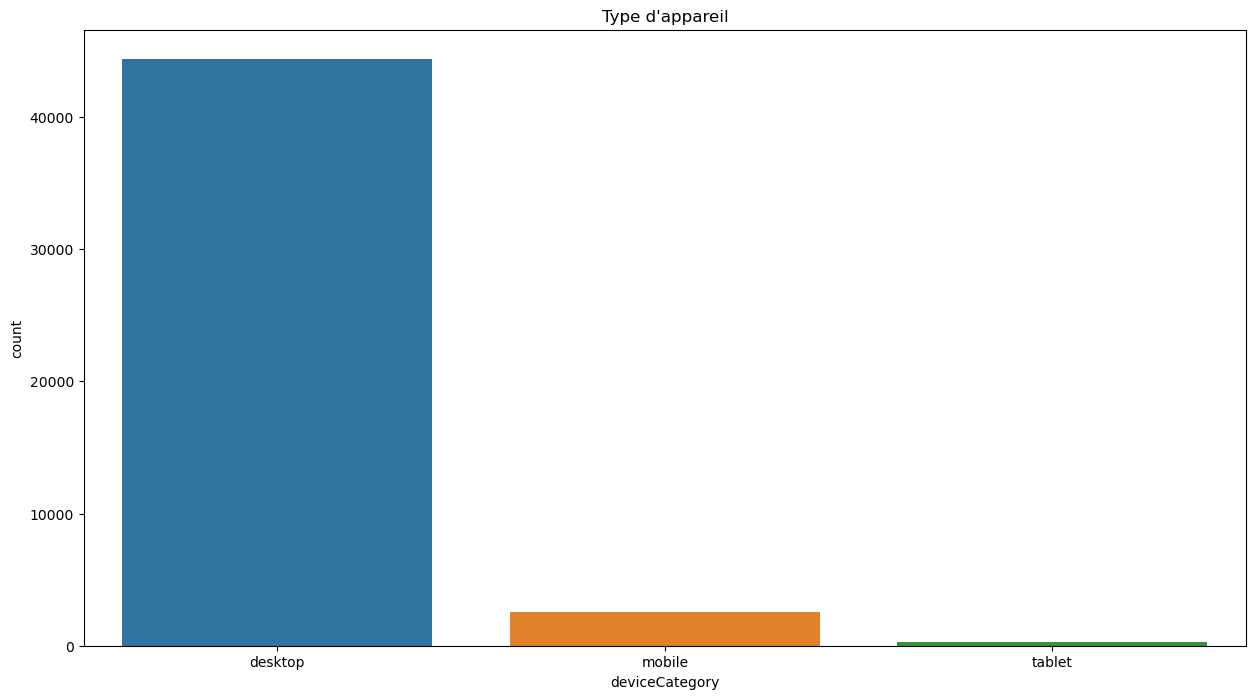

In [100]:
plt.figure(figsize=(15,8))
sns.countplot(df_visu['deviceCategory'])
plt.title(label='Type d\'appareil')
plt.show()

In [101]:
#change categorial columns
categorial = df_visu[['channelGrouping','deviceCategory', 'country']]

for i in categorial.columns:
    df_visu[i]= LabelEncoder().fit_transform(df_visu[i])
    df_visu[i].unique()
    
categorial

,channelGrouping,deviceCategory,country
fullVisitorId,,,
5777438125314310020,Organic Search,desktop,United States
5777438125314310020,Organic Search,desktop,United States
5777438125314310020,Organic Search,desktop,United States
5777438125314310020,Organic Search,desktop,United States
7209403264301039802,Direct,desktop,United States
...,...,...,...
4362490200806308515,Direct,desktop,(not set)
6737381346243471980,Direct,desktop,(not set)
3763043934585916260,Direct,desktop,(not set)


In [102]:
for i in categorial.columns:
    print(categorial[i].value_counts())
    print('-----------------------------')

Direct            29617
Organic Search    13025
Referral           3543
Email               646
(Other)             335
Paid Search          29
Display              22
Social                3
Name: channelGrouping, dtype: int64
-----------------------------
desktop    44386
mobile      2543
tablet       291
Name: deviceCategory, dtype: int64
-----------------------------
United States    37584
(not set)         9004
India              233
Canada             137
Germany            111
France              93
China               58
Name: country, dtype: int64
-----------------------------


In [103]:
# 1 = YES / 0 = NO

categorial["target"] = df_visu["will_buy_on_return_visit"]

C:\Users\Simplon\AppData\Local\Temp\ipykernel_4536\4040345609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorial["target"] = df_visu["will_buy_on_return_visit"]


C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


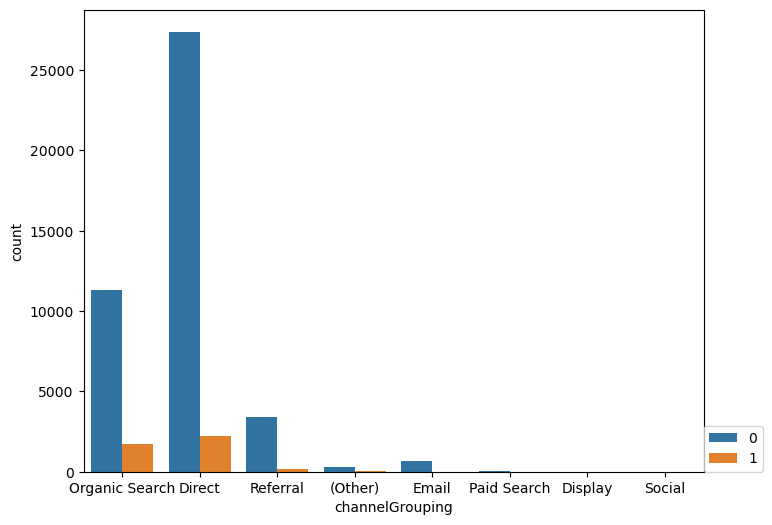

---------------------------------------------------------------------


C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


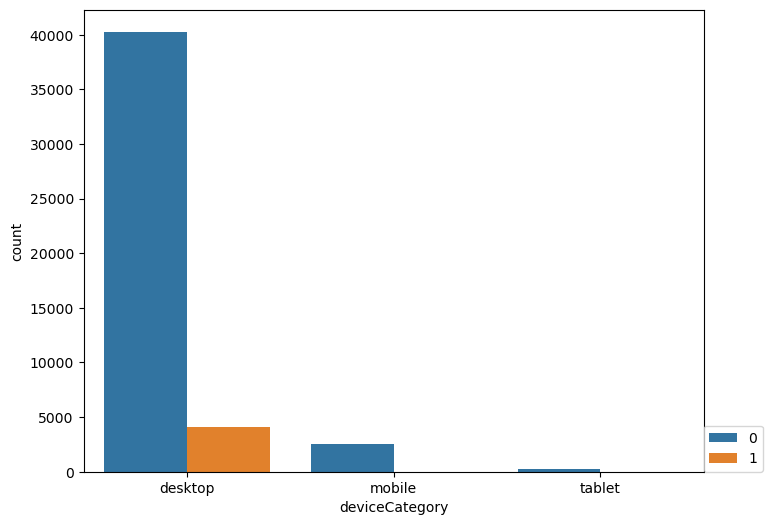

---------------------------------------------------------------------


C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


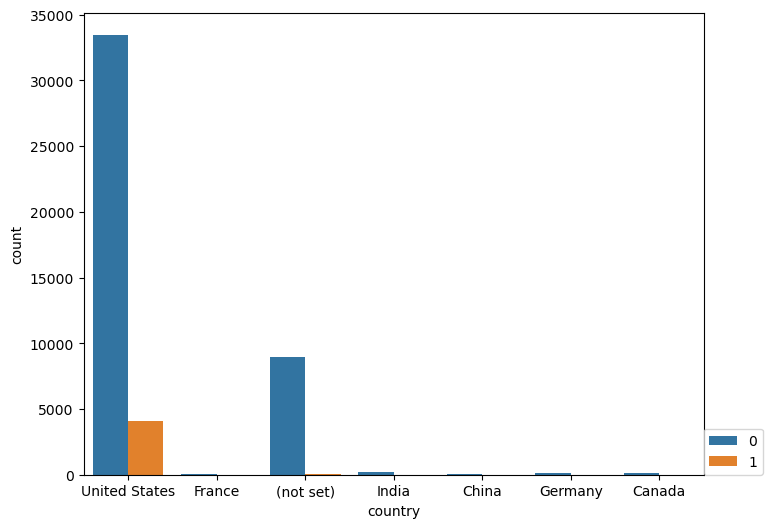

---------------------------------------------------------------------


In [104]:
for i in categorial.iloc[:,:-1].columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(i,hue="target", data= categorial)
    plt.legend(['0','1'],loc=(1,0))
    plt.show()
    print('---------------------------------------------------------------------')

### test

In [31]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


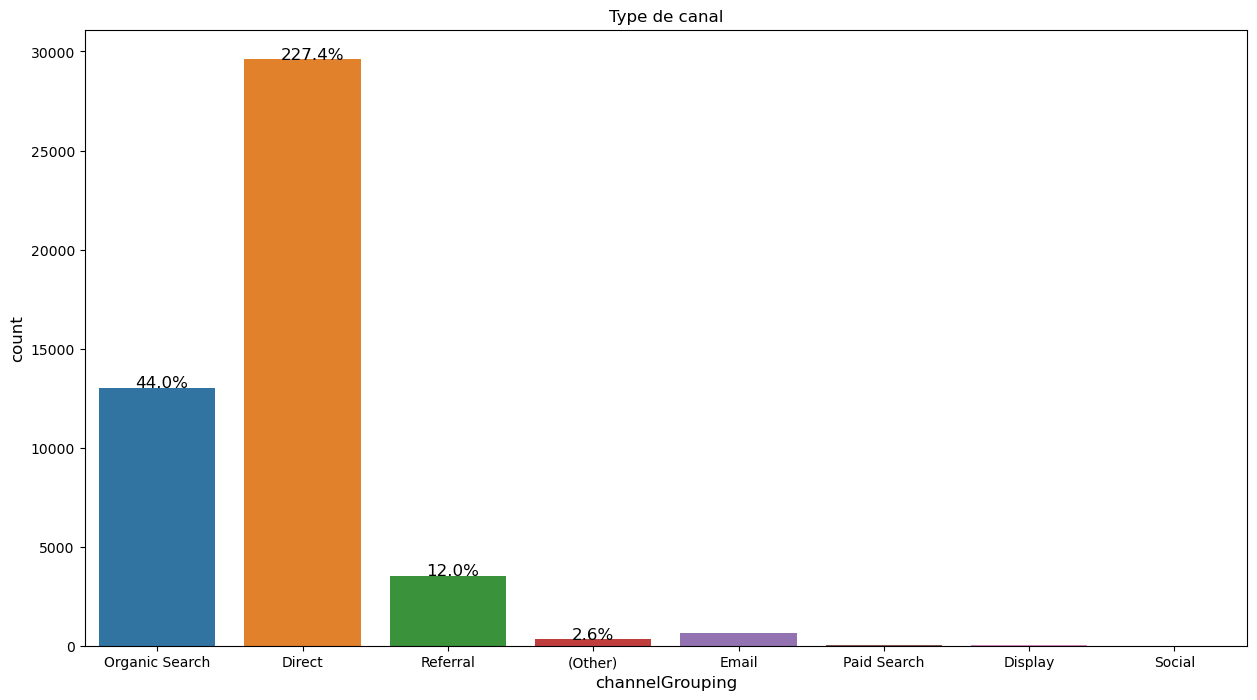

In [46]:
plt.figure(figsize=(15,8))
ax = sns.countplot('channelGrouping',
                   data= df_visu)
plt.xticks(size=10)
plt.xlabel('channelGrouping', size=12)
plt.yticks(size=10)
plt.ylabel('count', size=12)
plt.title(label='Type de canal')
with_hue(ax, df_visu.channelGrouping,2,2)
plt.show()

In [82]:
df_groupby = pd.DataFrame()

In [85]:
df_bar = df_visu.copy()

In [86]:
df_groupby = df_bar.groupby("channelGrouping").agg({"channelGrouping": "count"})
df_groupby['percent'] = df_groupby["count"] / len(df_bar)
sns.barplot(x=df_groupby.index, y =df_groupby.percent)

KeyError: 'count'

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


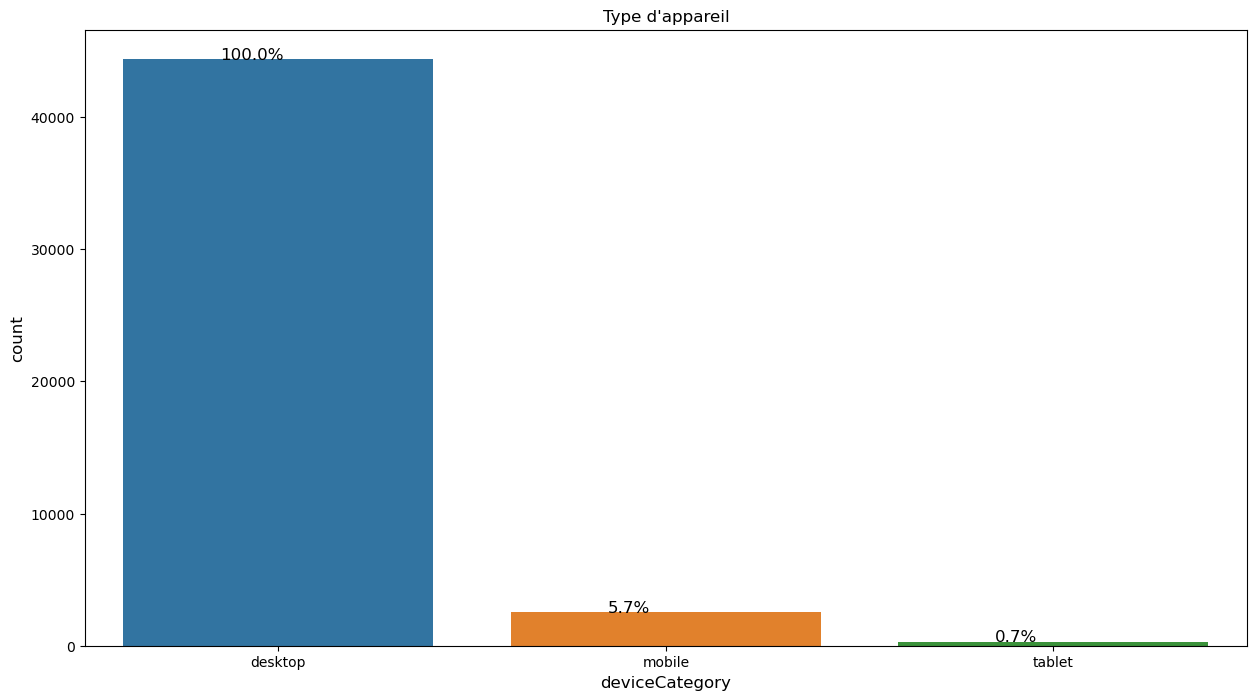

In [41]:
plt.figure(figsize=(15,8))
ax = sns.countplot('deviceCategory',
                   data= df_visu)
plt.xticks(size=10)
plt.xlabel('deviceCategory', size=12)
plt.yticks(size=10)
plt.ylabel('count', size=12)
plt.title(label='Type d\'appareil')
with_hue(ax, df_visu.deviceCategory,1,3)
plt.show()

In [111]:
df_groupby = pd.DataFrame()

In [112]:
df_bar = df_visu.copy()

In [113]:
# df_groupby = df_bar.groupby("channelGrouping").agg({"channelGrouping" : "count"})
# df_groupby['percent'] = df_groupby["channelGrouping"] / len(df_bar)

# plt.figure(figsize=(15,8))
# sns.barplot(x= df_groupby.index, y= df_groupby.percent)
# plt.xticks(size=10)
# plt.yticks(size=10)
# plt.title(label='Type de canal')

In [147]:
df_groupby

,channelGrouping,percent
channelGrouping,,
(Other),335,0.007094
Direct,29617,0.627213
Display,22,0.000466
Email,646,0.013681
Organic Search,13025,0.275837
Paid Search,29,0.000614
Referral,3543,0.075032
Social,3,0.000064


In [152]:
df_bar

,bounces,time_on_site,will_buy_on_return_visit,pageviews,channelGrouping,deviceCategory,country
fullVisitorId,,,,,,,
5777438125314310020,0,12884,0,169.0,Organic Search,desktop,United States
5777438125314310020,0,12884,0,1.0,Organic Search,desktop,United States
5777438125314310020,0,12884,0,8.0,Organic Search,desktop,United States
5777438125314310020,0,12884,1,178.0,Organic Search,desktop,United States
7209403264301039802,0,8793,0,1.0,Direct,desktop,United States
...,...,...,...,...,...,...,...
4362490200806308515,1,0,0,1.0,Direct,desktop,(not set)
6737381346243471980,1,0,0,1.0,Direct,desktop,(not set)
3763043934585916260,1,0,0,1.0,Direct,desktop,(not set)


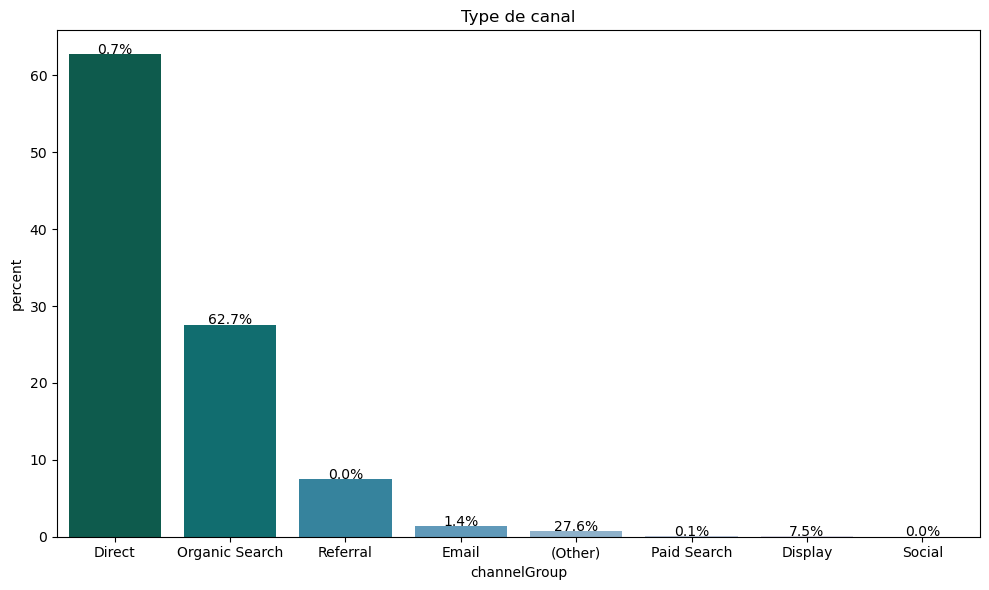

In [162]:
plt.rcParams["figure.figsize"] = [10.00, 6.00]
plt.rcParams["figure.autolayout"] = True

df_groupby = df_bar.groupby("channelGrouping").agg({"time_on_site" : "count"}).reset_index()
df_groupby.columns = ["channelGroup",'count']
df_groupby['percent'] = df_groupby["count"] / len(df_bar) * 100
df_groupby = df_groupby.sort_values("percent",ascending=False)

ax = sns.barplot(x= df_groupby["channelGroup"], y=df_groupby["percent"], palette='PuBuGn_r')
plt.xticks(size=10)
plt.yticks(size=10)
plt.title(label='Type de canal')

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.1f}%'.format(df_groupby.percent[i]), (x, y), ha='center')

plt.show()

In [163]:
df_groupby2 = pd.DataFrame()

In [164]:
df_bar2 = df_visu.copy()

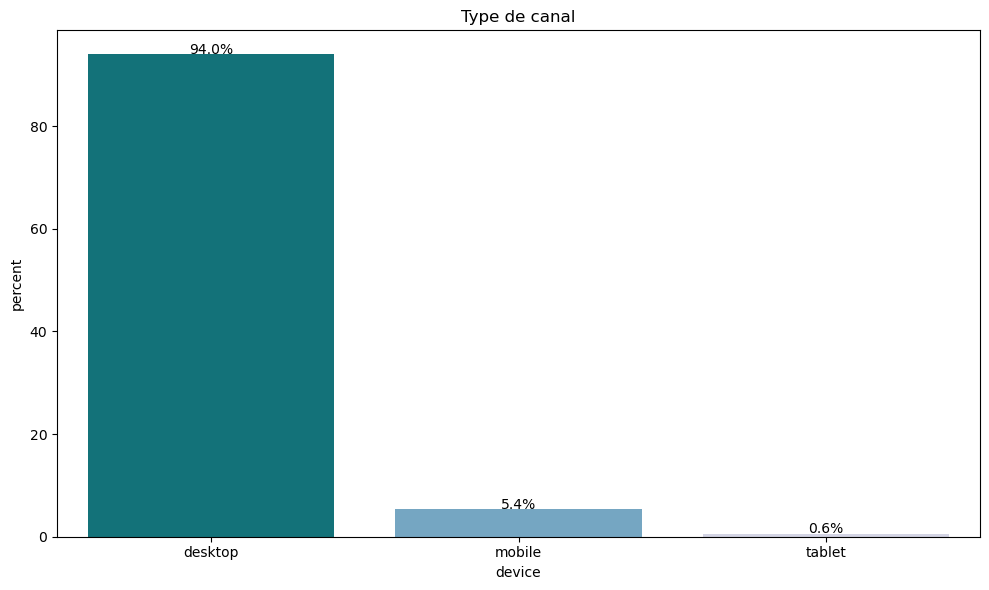

In [165]:
plt.rcParams["figure.figsize"] = [10.00, 6.00]
plt.rcParams["figure.autolayout"] = True

df_groupby2 = df_bar2.groupby("deviceCategory").agg({"time_on_site" : "count"}).reset_index()
df_groupby2.columns = ["device",'count']
df_groupby2['percent'] = df_groupby2["count"] / len(df_bar2) * 100
df_groupby2 = df_groupby2.sort_values("percent",ascending=False)

ax = sns.barplot(x= df_groupby2["device"], y=df_groupby2["percent"], palette='PuBuGn_r')
plt.xticks(size=10)
plt.yticks(size=10)
plt.title(label='Type de canal')

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.1f}%'.format(df_groupby2.percent[i]), (x, y), ha='center')

plt.show()

### Integer data 

In [105]:
integer = df_visu[['bounces','time_on_site','pageviews']].copy()

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings

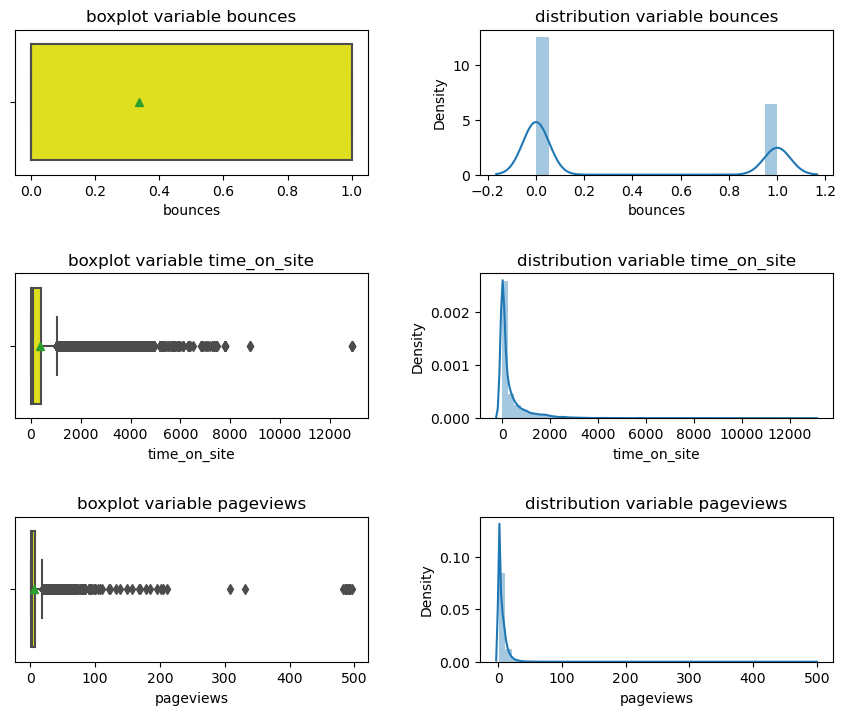

In [106]:
#on définie notre subplot
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(10,8))
#Variable pour parcourir notre subplot(position)
n=0
#Espace entre les plots
fig.tight_layout(pad=5.0)

#On initie la boucle avec notre list de colonnes 
for i in integer.columns:
    #On affiche les boxplot de chaque variable sur l'axe de gauche
    #On fixe le titre
    axes[n,0].set_title(f'boxplot variable {i}')
    #On plot notre box
    sns.boxplot(i,data=integer,ax=axes[n,0],color="Yellow",showmeans=True)
    #On fixe notre titre
    axes[n,1].set_title(f'distribution variable {i}')
    #On plot notre distribution
    sns.distplot(integer[i],ax=axes[n,1])
    #On incrémente notre seconde variable
    n=n+1

In [107]:
integer['bounces'].value_counts()

0    31244
1    15976
Name: bounces, dtype: int64

In [108]:
integer_time = integer.copy()[integer["time_on_site"]<4000]
integer_page = integer.copy()[integer["pageviews"]<200]

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


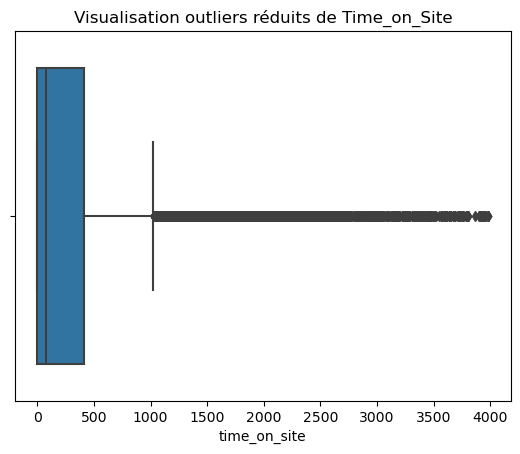

In [109]:
sns.boxplot(integer_time["time_on_site"])
plt.title(label='Visualisation outliers réduits de Time_on_Site')
plt.show()

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


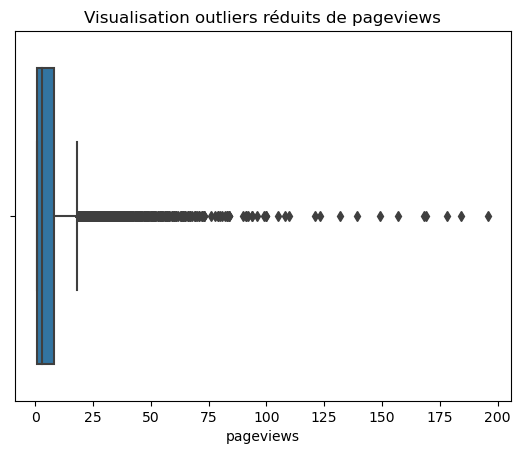

In [110]:
sns.boxplot(integer_page["pageviews"])
plt.title(label='Visualisation outliers réduits de pageviews')
plt.show()

### Correlation

In [52]:
df_visu["target"]= df_visu['will_buy_on_return_visit']
df_visu = df_visu.drop("will_buy_on_return_visit",axis=1)

C:\Users\Simplon\AppData\Local\Temp\ipykernel_20328\2211278395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_visu["target"]= df_visu['will_buy_on_return_visit']


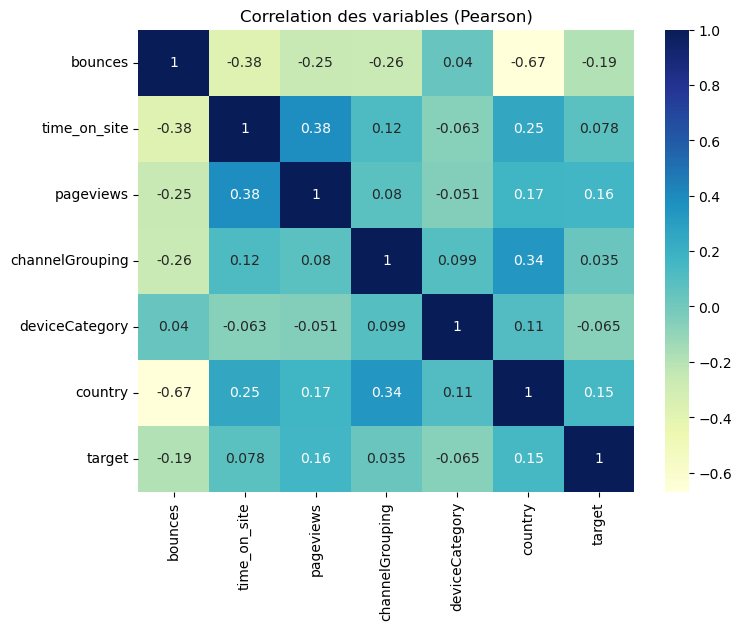

In [112]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_visu.corr(), cmap= "YlGnBu", annot=True)
plt.title(label="Correlation des variables (Pearson)")
plt.show()

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


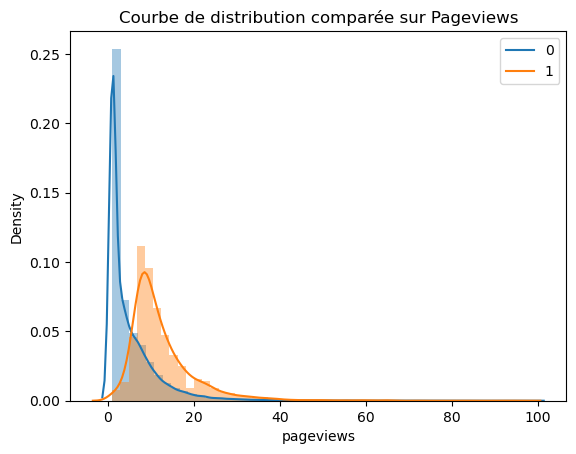

In [113]:
sns.distplot(df_visu[(df_visu["target"]==0)&(df_visu['pageviews']<100)]["pageviews"])
sns.distplot(df_visu[(df_visu["target"]==1)&(df_visu['pageviews']<100)]["pageviews"])
plt.legend(["0","1"])
plt.title("Courbe de distribution comparée sur Pageviews")
plt.show()

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


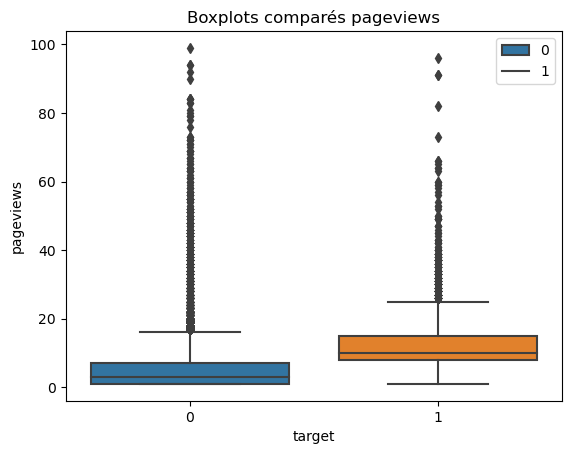

In [114]:
sns.boxplot('target','pageviews',data= df_visu[df_visu["pageviews"]<100])
plt.legend(["0","1"])
plt.title("Boxplots comparés pageviews")
plt.show()

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


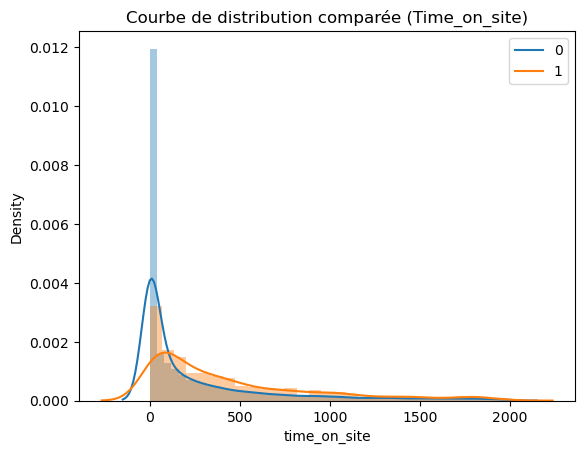

In [115]:
sns.distplot(df_visu[(df_visu["target"]==0)&(df_visu['time_on_site']<2000)]["time_on_site"])
sns.distplot(df_visu[(df_visu["target"]==1)&(df_visu['time_on_site']<2000)]["time_on_site"])
plt.legend(["0","1"])
plt.title("Courbe de distribution comparée (Time_on_site)")
plt.show()

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


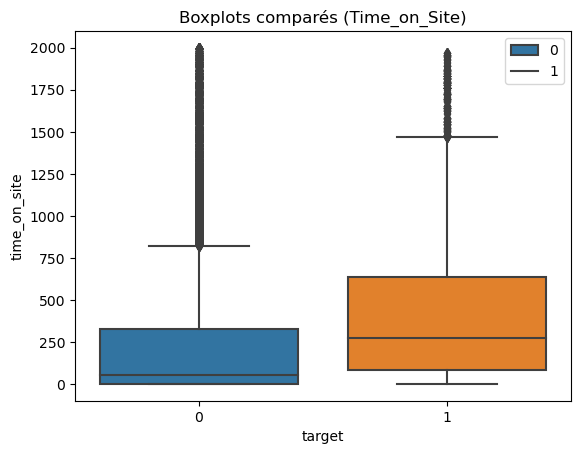

In [116]:
sns.boxplot('target','time_on_site',data= df_visu[df_visu["time_on_site"]<2000])
plt.legend(["0","1"])
plt.title("Boxplots comparés (Time_on_Site)")
plt.show()

C:\Users\Simplon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


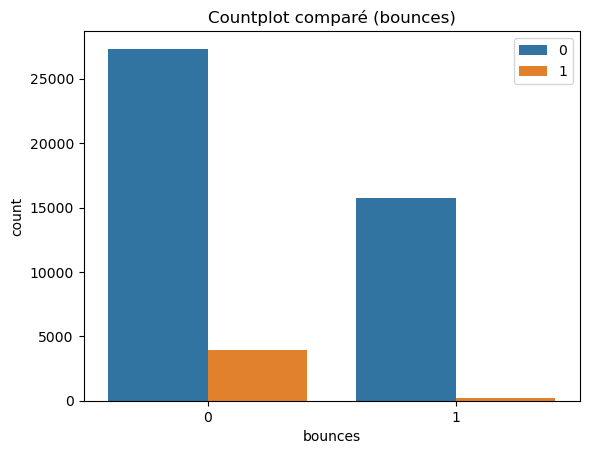

In [117]:
sns.countplot("bounces", hue="target", data= df_visu)
plt.legend()
plt.title('Countplot comparé (bounces)')
plt.show()

In [118]:
df_visu[df_visu['target'] == 0]['bounces'].value_counts(normalize = True)

0    0.634403
1    0.365597
Name: bounces, dtype: float64

In [119]:
df_visu[df_visu['target'] == 1]['bounces'].value_counts(normalize = True)

0    0.945613
1    0.054387
Name: bounces, dtype: float64

# Preprocessing

In [53]:
df_visu = df_visu.dropna(axis=0)

In [54]:
# df_tpot = df_visu.copy()
# df_tpot = df_tpot.dropna()
# print(df_tpot.value_counts().sum())

In [55]:
df_model = df_visu.copy()

In [56]:
X = df_model.drop('target', axis=1)
y = df_model['target']

In [57]:
X

,bounces,time_on_site,pageviews,channelGrouping,deviceCategory,country
fullVisitorId,,,,,,
5777438125314310020,0,12884,169.0,Organic Search,desktop,United States
5777438125314310020,0,12884,1.0,Organic Search,desktop,United States
5777438125314310020,0,12884,8.0,Organic Search,desktop,United States
5777438125314310020,0,12884,178.0,Organic Search,desktop,United States
7209403264301039802,0,8793,1.0,Direct,desktop,United States
...,...,...,...,...,...,...
4362490200806308515,1,0,1.0,Direct,desktop,(not set)
6737381346243471980,1,0,1.0,Direct,desktop,(not set)
3763043934585916260,1,0,1.0,Direct,desktop,(not set)


In [58]:
y

fullVisitorId
5777438125314310020    0
5777438125314310020    0
5777438125314310020    0
5777438125314310020    1
7209403264301039802    0
                      ..
4362490200806308515    0
6737381346243471980    0
3763043934585916260    0
1512694728925216829    0
2625321494606109308    0
Name: target, Length: 47014, dtype: int64

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**IMPORTANT : À partir de là, j'ai juste LabelEncoder**

# OneHotEncoder*

In [60]:
data_bq = pd.read_csv("data/bquxjob_4a55ecd5_184c3af4fbe.csv")

In [61]:
data_bq.set_index('fullVisitorId')

,bounces,time_on_site,will_buy_on_return_visit,pageviews,medium,channelGrouping,deviceCategory,country,date
fullVisitorId,,,,,,,,,
5777438125314310020,0,12884,0,169.0,organic,Organic Search,desktop,United States,20220919
5777438125314310020,0,12884,0,1.0,organic,Organic Search,desktop,United States,20220919
5777438125314310020,0,12884,0,8.0,organic,Organic Search,desktop,United States,20220919
5777438125314310020,0,12884,1,178.0,organic,Organic Search,desktop,United States,20220919
7209403264301039802,0,8793,0,1.0,(none),Direct,desktop,United States,20220928
...,...,...,...,...,...,...,...,...,...
4362490200806308515,1,0,0,1.0,(none),Direct,desktop,(not set),20220924
6737381346243471980,1,0,0,1.0,(none),Direct,desktop,(not set),20220924
3763043934585916260,1,0,0,1.0,(none),Direct,desktop,(not set),20220924


In [62]:
# df_best_country = df.copy()[df["country"].isin(["United States", "France", 
#                                                 "India", "China", "Germany",
#                                                 "Canada"])]
# df_best_country['country'].value_counts(ascending=False)

In [63]:
df_data_bq = data_bq.drop(['medium','date'], axis= 1)
df_data_bq

,fullVisitorId,bounces,time_on_site,will_buy_on_return_visit,pageviews,channelGrouping,deviceCategory,country
0,5777438125314310020,0,12884,0,169.0,Organic Search,desktop,United States
1,5777438125314310020,0,12884,0,1.0,Organic Search,desktop,United States
2,5777438125314310020,0,12884,0,8.0,Organic Search,desktop,United States
3,5777438125314310020,0,12884,1,178.0,Organic Search,desktop,United States
4,7209403264301039802,0,8793,0,1.0,Direct,desktop,United States
...,...,...,...,...,...,...,...,...
48049,4362490200806308515,1,0,0,1.0,Direct,desktop,(not set)
48050,6737381346243471980,1,0,0,1.0,Direct,desktop,(not set)
48051,3763043934585916260,1,0,0,1.0,Direct,desktop,(not set)
48052,1512694728925216829,1,0,0,1.0,Direct,desktop,United States


In [64]:
df_data_bq["target"]= df_data_bq['will_buy_on_return_visit']
df_data_bq = df_data_bq.drop("will_buy_on_return_visit",axis=1)

In [66]:
data_bq_model= df_data_bq.dropna(axis=0)

In [67]:
data_bq_model

,fullVisitorId,bounces,time_on_site,pageviews,channelGrouping,deviceCategory,country,target
0,5777438125314310020,0,12884,169.0,Organic Search,desktop,United States,0
1,5777438125314310020,0,12884,1.0,Organic Search,desktop,United States,0
2,5777438125314310020,0,12884,8.0,Organic Search,desktop,United States,0
3,5777438125314310020,0,12884,178.0,Organic Search,desktop,United States,1
4,7209403264301039802,0,8793,1.0,Direct,desktop,United States,0
...,...,...,...,...,...,...,...,...
48049,4362490200806308515,1,0,1.0,Direct,desktop,(not set),0
48050,6737381346243471980,1,0,1.0,Direct,desktop,(not set),0
48051,3763043934585916260,1,0,1.0,Direct,desktop,(not set),0
48052,1512694728925216829,1,0,1.0,Direct,desktop,United States,0


In [68]:
categorial = data_bq_model[['channelGrouping','deviceCategory', 'country']]

In [72]:
from sklearn.preprocessing import OneHotEncoder
ohenc = OneHotEncoder()
ohenc.fit_transform(categorial)

<47841x114 sparse matrix of type '<class 'numpy.float64'>'
	with 143523 stored elements in Compressed Sparse Row format>

In [74]:
data_bq_encoded = data_bq_model.copy()

In [75]:
encoder=OneHotEncoder(sparse=False)

data_bq_encoded = pd.DataFrame (encoder.fit_transform(categorial[['country']]))

data_bq_encoded.columns = encoder.get_feature_names(['country'])

categorial.drop(['country'] ,axis=1, inplace=True)

OH_X_train= pd.concat([categorial, data_bq_encoded], axis=1)

C:\Users\Simplon\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

In [70]:
ohenc.get_feature_names()
data_bq_model.columns = ohenc.get_feature_names()

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

In [ ]:

for i in categorial.columns:
    data_bq_model[i]= LabelEncoder().fit_transform(data_bq_model[i])
    data_bq_model[i].unique()
    
categorial

## Resample Data (rééquilibre)

In [127]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.75)
steps = [('over', over), ('under', under)]
pipeline_smote = Pipeline(steps=steps)

In [128]:
df_resample_X , df_resample_y = pipeline_smote.fit_resample(X_train, y_train)

In [129]:
df_resample_X

,bounces,time_on_site,pageviews,channelGrouping,deviceCategory,country
0,0,1316,18.000000,1,0,6
1,0,837,14.000000,1,0,6
2,0,629,11.000000,1,0,6
3,0,5722,4.000000,6,0,6
4,1,0,1.000000,1,0,6
...,...,...,...,...,...,...
13978,0,987,7.398316,4,0,6
13979,0,37,10.335532,4,0,6
13980,0,450,11.523717,1,0,6
13981,0,180,8.223183,1,0,6


In [130]:
df_resample_y.value_counts()

0    7990
1    5993
Name: target, dtype: int64

In [131]:
# # define pipeline

# #model = DecisionTreeClassifier()
# tpot = TPOTClassifier(generations=5, population_size=20, cv=5, scoring= 'roc_auc',
#                       random_state=42, verbosity=2)

# #create pipeline
# steps = [('tpot', tpot)]
# pipeline_optimizer = Pipeline(steps=steps)

In [132]:
# pipeline_optimizer.fit(df_resample_X, df_resample_y)

In [133]:
# voir l'intérieur de la pipeline
# tpot.fitted_pipeline_

In [134]:
#define model in pipeline
# model = tpot.fitted_pipeline_

In [135]:
#Results

# y_pred = model.predict(X_test)

# print(f'Score:', model.score(X_test, y_test))
# print(f'Prediction:', model.predict(X_test))
# print(f'Evaluation:')
# print_binary_evaluation(y_test, y_pred)

In [136]:
#report

# print(classification_report(y_test, y_pred))
# print('------------------------------------')

# #confusion matrix
# conf_mat = confusion_matrix(y_test, y_pred)
# sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds")
# plt.title("Confusion matrix après TPOT")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

## Dictionnaire des modèles

In [137]:
#Preparation des évaluations avec une fonction

def print_binary_evaluation(y_true, y_pred):
    results_dict = {'accuracy': accuracy_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred),
                    'f1_score': f1_score(y_true, y_pred)}
    return results_dict

In [138]:
model_dico = {"RandomForestClassifier": RandomForestClassifier(random_state=42),
              "AdaBoostClassifier" : AdaBoostClassifier(random_state=42),
              "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    
             'RandomForestClassifierTPOT': RandomForestClassifier(criterion='entropy', 
                                                  max_features=0.05,
                                                  min_samples_leaf=4,
                                                  min_samples_split=19,
                                                  random_state=42),
              
              'XGBoostClassifier' : XGBClassifier(random_state=42),
              
              'LogisticRegression': LogisticRegression(random_state=42),
              
             }

In [139]:
model_dico

{'RandomForestClassifier': RandomForestClassifier(random_state=42),
 'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
 'RandomForestClassifierTPOT': RandomForestClassifier(criterion='entropy', max_features=0.05,
                        min_samples_leaf=4, min_samples_split=19,
                        random_state=42),
 'XGBoostClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_ch

In [140]:
normalisation = {'std_scaler' : StandardScaler(),
                 'minmax_scaler' : MinMaxScaler()
                }

In [141]:
normalisation

{'std_scaler': StandardScaler(), 'minmax_scaler': MinMaxScaler()}

In [142]:
results = {}
metrics_df = pd.DataFrame()
acc_lst = []
recall_lst = []
precision_lst = []
f1_score_lst = []
roc_auc_score_lst = []
model_lst = []
scaler_type = []
balancing = []

for i in model_dico.keys():
    tmp_model = model_dico[i]
    for n in normalisation.keys():        
        tmp_model.fit(normalisation[n].fit_transform(df_resample_X), df_resample_y)
        test_mod_name = f"{i}_with_{n}"
        results[test_mod_name] = X_test.copy()
        results[test_mod_name]['predict'] = tmp_model.predict(normalisation[n].fit_transform(X_test))
        results[test_mod_name]['Actual'] = y_test
        results[test_mod_name]['proba_0'] = tmp_model.predict_proba(normalisation[n].fit_transform(X_test))[:,0]
        results[test_mod_name]['proba_1'] = tmp_model.predict_proba(normalisation[n].fit_transform(X_test))[:,1]
        model_lst.append(i)
        scaler_type.append(n)
        acc_tmp = accuracy_score(results[test_mod_name]['Actual'],results[test_mod_name]['predict'])
        recall_tmp = recall_score(results[test_mod_name]['Actual'],results[test_mod_name]['predict'])
        precision_tmp = precision_score(results[test_mod_name]['Actual'],results[test_mod_name]['predict'])
        f1_tmp = f1_score(results[test_mod_name]['Actual'],results[test_mod_name]['predict'])
        roc_auc_score_tmp = roc_auc_score(results[test_mod_name]['Actual'],results[test_mod_name]['predict'])
        acc_lst.append(acc_tmp)
        recall_lst.append(recall_tmp)
        precision_lst.append(precision_tmp)
        f1_score_lst.append(f1_tmp)
        roc_auc_score_lst.append(roc_auc_score_tmp)
        balancing.append("Smote+Under")
        
for i in model_dico.keys():
    tmp_model = model_dico[i]
    for n in normalisation.keys():        
        tmp_model.fit(normalisation[n].fit_transform(X_train), y_train)
        test_mod_name = f"{i}_with_{n}"
        results[test_mod_name] = X_test.copy()
        results[test_mod_name]['predict'] = tmp_model.predict(normalisation[n].fit_transform(X_test))
        results[test_mod_name]['Actual'] = y_test
        results[test_mod_name]['proba_0'] = tmp_model.predict_proba(normalisation[n].fit_transform(X_test))[:,0]
        results[test_mod_name]['proba_1'] = tmp_model.predict_proba(normalisation[n].fit_transform(X_test))[:,1]
        model_lst.append(i)
        scaler_type.append(n)
        acc_tmp = accuracy_score(results[test_mod_name]['Actual'],results[test_mod_name]['predict'])
        recall_tmp = recall_score(results[test_mod_name]['Actual'],results[test_mod_name]['predict'])
        precision_tmp = precision_score(results[test_mod_name]['Actual'],results[test_mod_name]['predict'])
        f1_tmp = f1_score(results[test_mod_name]['Actual'],results[test_mod_name]['predict'])
        roc_auc_score_tmp = roc_auc_score(results[test_mod_name]['Actual'],results[test_mod_name]['predict'])
        acc_lst.append(acc_tmp)
        recall_lst.append(recall_tmp)
        precision_lst.append(precision_tmp)
        f1_score_lst.append(f1_tmp)
        roc_auc_score_lst.append(roc_auc_score_tmp)
        balancing.append("Raw")

C:\Users\Simplon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Simplon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
results['XGBoostClassifier_with_minmax_scaler'][(results['XGBoostClassifier_with_minmax_scaler']['proba_1']> 0.45) & (results['XGBoostClassifier_with_minmax_scaler']['proba_1'] < 0.7)]

,bounces,time_on_site,pageviews,channelGrouping,deviceCategory,country,predict,Actual,proba_0,proba_1
fullVisitorId,,,,,,,,,,
1296710461515425134,0,19,21.0,1,0,6,1,0,0.380142,0.619858
5260202412221374599,0,57,8.0,1,0,6,1,0,0.482270,0.517730
8287628321193416733,0,53,10.0,1,0,6,1,0,0.396090,0.603910
1049354893848481873,1,0,23.0,4,0,6,1,0,0.310044,0.689956
8363637950863592159,1,0,8.0,4,0,6,0,0,0.540440,0.459560
...,...,...,...,...,...,...,...,...,...,...
6276817052310839171,0,357,25.0,1,0,6,1,1,0.417255,0.582745
9190045969897024015,0,131,12.0,1,0,6,0,0,0.546844,0.453156
7288410076718387844,0,92,12.0,1,0,6,1,1,0.459834,0.540166


In [144]:
metrics_df["model"]= model_lst
metrics_df["scaler type using"] = scaler_type
metrics_df['balancing_process']=balancing
metrics_df["accuracy score"] = acc_lst
metrics_df["recall score"] = recall_lst
metrics_df["precision score"] = precision_lst
metrics_df["f1 score"] = f1_score_lst
metrics_df["roc_auc_score"] = roc_auc_score_lst


In [145]:
metrics_df.sort_values("f1 score",ascending=False).style.background_gradient(cmap = "YlGn")

,model,scaler type using,balancing_process,accuracy score,recall score,precision score,f1 score,roc_auc_score
9,XGBoostClassifier,minmax_scaler,Smote+Under,0.774973,0.806856,0.246929,0.378135,0.789438
7,RandomForestClassifierTPOT,minmax_scaler,Smote+Under,0.754484,0.837793,0.234605,0.366563,0.792279
3,AdaBoostClassifier,minmax_scaler,Smote+Under,0.727260,0.888796,0.222525,0.355935,0.800545
1,RandomForestClassifier,minmax_scaler,Smote+Under,0.758951,0.742475,0.223116,0.343122,0.751476
5,DecisionTreeClassifier,minmax_scaler,Smote+Under,0.771216,0.640468,0.214987,0.321916,0.711899
17,DecisionTreeClassifier,minmax_scaler,Raw,0.885218,0.297659,0.313656,0.305448,0.618657
10,LogisticRegression,std_scaler,Smote+Under,0.628784,0.908863,0.174928,0.293387,0.755849
11,LogisticRegression,minmax_scaler,Smote+Under,0.637008,0.846990,0.170252,0.283515,0.732272
2,AdaBoostClassifier,std_scaler,Smote+Under,0.578873,0.934783,0.160172,0.273483,0.740340
13,RandomForestClassifier,minmax_scaler,Raw,0.884934,0.246656,0.290069,0.266606,0.595363


In [146]:
y_true_actu = results["RandomForestClassifier_with_minmax_scaler"]['Actual']

In [147]:
y_probability = results["RandomForestClassifier_with_minmax_scaler"]['proba_1']

In [148]:
metrics.plot_roc_curve(y_true_actu, y_probability)
plt.show()

C:\Users\Simplon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


TypeError: plot_roc_curve() missing 1 required positional argument: 'y'

# Model Tuning (RandomForest)

In [149]:
# RandomForestClassifier 's parameters

estimator_param = RandomForestClassifier(random_state=42)

param_grid = { 
    'classifier__n_estimators': [50,100,150,200],
    'classifier__criterion':['gini', 'entropy'],
    'classifier__min_samples_split': [19],
    'classifier__min_samples_leaf':[4],
    'classifier__max_features' : [0.05,0.10,0.15],
    "classifier__random_state" : [42]
}

In [150]:
rnd_search = GridSearchCV(estimator= estimator_param, param_grid= param_grid, scoring='f1', cv=5, verbose=1,
                          return_train_score=True,
                          refit=True)

In [151]:
for param in rnd_search.get_params().keys():
    print(param)

cv
error_score
estimator__bootstrap
estimator__ccp_alpha
estimator__class_weight
estimator__criterion
estimator__max_depth
estimator__max_features
estimator__max_leaf_nodes
estimator__max_samples
estimator__min_impurity_decrease
estimator__min_samples_leaf
estimator__min_samples_split
estimator__min_weight_fraction_leaf
estimator__n_estimators
estimator__n_jobs
estimator__oob_score
estimator__random_state
estimator__verbose
estimator__warm_start
estimator
n_jobs
param_grid
pre_dispatch
refit
return_train_score
scoring
verbose


In [152]:
#create pipeline

pipe_classifier = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [153]:
clf = GridSearchCV(estimator= pipe_classifier,
             param_grid= param_grid,
             scoring='f1',
             cv=5,
             verbose=3,
             return_train_score=True,
             refit=True)

In [154]:
pipe_classifier.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmax_scaler', 'classifier', 'minmax_scaler__clip', 'minmax_scaler__copy', 'minmax_scaler__feature_range', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

In [155]:
print(pipe_classifier)

Pipeline(steps=[('minmax_scaler', MinMaxScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])


In [156]:
#search best param for model

clf.fit(df_resample_X, df_resample_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END classifier__criterion=gini, classifier__max_features=0.05, classifier__min_samples_leaf=4, classifier__min_samples_split=19, classifier__n_estimators=50, classifier__random_state=42;, score=(train=0.870, test=0.772) total time=   0.4s
[CV 2/5] END classifier__criterion=gini, classifier__max_features=0.05, classifier__min_samples_leaf=4, classifier__min_samples_split=19, classifier__n_estimators=50, classifier__random_state=42;, score=(train=0.872, test=0.752) total time=   0.3s
[CV 3/5] END classifier__criterion=gini, classifier__max_features=0.05, classifier__min_samples_leaf=4, classifier__min_samples_split=19, classifier__n_estimators=50, classifier__random_state=42;, score=(train=0.849, test=0.831) total time=   0.3s
[CV 4/5] END classifier__criterion=gini, classifier__max_features=0.05, classifier__min_samples_leaf=4, classifier__min_samples_split=19, classifier__n_estimators=50, classifier__random_state=42

KeyboardInterrupt: 

In [ ]:
best_estim= clf.best_estimator_
print(best_estim)

## second test GridSearchCV RandomForest

In [ ]:
pipe_classifier_second = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("classifier", RandomForestClassifier())
])

In [ ]:
param_grid_second = { 
    'classifier__n_estimators': [200,300,500],
    'classifier__criterion':['gini', 'entropy'],
    'classifier__min_samples_split': [19],
    'classifier__min_samples_leaf':[4],
    'classifier__max_features' : [0.05],
    "classifier__random_state" : [42]
}

In [ ]:
second_clf = GridSearchCV(estimator= pipe_classifier_second,
             param_grid= param_grid_second,
             scoring='f1',
             cv=5,
             verbose=3,
             return_train_score=True,
             refit=True)

In [ ]:
print(pipe_classifier_second)

In [ ]:
#search best param for model

second_clf.fit(df_resample_X, df_resample_y)

In [ ]:
second_clf.best_estimator_

In [ ]:
second_clf.best_score_

In [ ]:
second_clf.best_params_

## GridSearchCV for XGBoost Classifier

In [ ]:
estimator_param_boost = XGBClassifier(random_state=42)

In [ ]:
# define param for XGBoostClassifier

param_grid_boost = { "classifier__n_estimators": [1000, 1500, 2000, 2500, 3000],
                    "classifier__learning_rate": [0.05, 0.01, 0.5, 0.1]
                   }

In [ ]:
rnd_search_boost = GridSearchCV(estimator= estimator_param_boost, 
                                param_grid= param_grid_boost, 
                                scoring='f1', 
                                cv=5, 
                                verbose=3,
                                return_train_score=True,
                                refit=True)

In [ ]:
for param in rnd_search_boost.get_params().keys():
    print(param)

In [ ]:
pipe_boost = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("classifier", XGBClassifier(random_state=42))
])

In [ ]:
model_boost = GridSearchCV(estimator= pipe_boost,
             param_grid= param_grid_boost,
             scoring='f1',
             cv=5,
             verbose=3,
             return_train_score=True,
             refit=True)

In [ ]:
model_boost.fit(df_resample_X, df_resample_y)

In [ ]:
model_boost.best_score_

In [ ]:
model_boost.best_estimator_

In [ ]:
model_boost.best_params_

## Seconde GridSearchCV for XGBoostClassifier

In [ ]:
# define param for XGBoostClassifier

param_grid_boost_second = { "classifier__n_estimators": [1000],
                            "classifier__learning_rate": [0.003],
                            "classifier__gamma": [0, 2, 5, 10, 50, 100],
                            "classifier__max_depth": [3, 6, 10]
                          }

In [ ]:
pipe_boost_second = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("classifier", XGBClassifier(random_state=42))
])

In [ ]:
model_boost_second = GridSearchCV(estimator= pipe_boost_second,
             param_grid= param_grid_boost_second,
             scoring='f1',
             cv=5,
             verbose=3,
             return_train_score=True,
             refit=True)

In [ ]:
model_boost_second.fit(df_resample_X, df_resample_y)

In [ ]:
model_boost_second.best_score_

In [ ]:
model_boost_second.best_estimator_

In [ ]:
model_boost_second.best_params_

## Third test

In [ ]:
# define param for XGBoostClassifier

param_grid_boost_three = { "classifier__n_estimators": [1000],
                            "classifier__learning_rate": [0.003],
                            "classifier__gamma": [ 0.2],
                            "classifier__max_depth": [6],
                            "classifier__alpha": [1e-5, 0.0001,0.00005,0.000005,0.000008]
                          }

In [ ]:
pipe_boost_three = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("classifier", XGBClassifier(random_state=42))
])

In [ ]:
model_boost_three = GridSearchCV(estimator= pipe_boost_three,
             param_grid= param_grid_boost_three,
             scoring='f1',
             cv=5,
             verbose=3,
             return_train_score=True,
             refit=True)

In [ ]:
model_boost_three.fit(df_resample_X, df_resample_y)

In [ ]:
model_boost_three.best_score_

In [ ]:
model_boost_three.best_estimator_

In [ ]:
model_boost_three.best_params_

# Modeling & Mlflow

In [157]:
# test unitaire _ metrics

def eval_metrics(actual,pred):
    accuracy = round(accuracy_score(actual,pred),2)
    precision= round(precision_score(actual,pred),2)
    recall = round(recall_score(actual,pred),2)
    f1 = round(f1_score(actual,pred),2)
    return accuracy,precision,recall,f1

def test_eval_metrics():
    ac = [0,1,1,0,0,1]  
    pr = [1,1,1,0,1,1]
    pr_accuracy,pr_precision,pr_recall,pr_f1 = eval_metrics(ac,pr)
    true_acc = 0.67
    true_pre = 0.6
    true_rec = 1.0
    true_f1 = 0.75
    assert((pr_accuracy == true_acc) & (pr_precision == true_pre) & (pr_recall == true_rec) & (pr_f1==true_f1))

test_eval_metrics()

```
if __name__ == "__main__":
    # Log a parameter (key-value pair)
    log_param("param1", randint(0, 100))

    # Log a metric; metrics can be updated throughout the run
    log_metric("foo", random())
    log_metric("foo", random() + 1)
    log_metric("foo", random() + 2)

    # Log an artifact (output file)
    if not os.path.exists("outputs"):
        os.makedirs("outputs")
    with open("outputs/test.txt", "w") as f:
        f.write("hello world!")
    log_artifacts("outputs")
 ```
 

In [158]:
mlflow.get_tracking_uri()

'file:///C:/Users/Simplon/Desktop/PROJET_FINAL_BEAUTY/Dossier_Project_E1/mlruns'

In [2]:
!mlflow ui

^C


[0]	validation_0-logloss:0.69158	validation_1-logloss:0.69151
[1]	validation_0-logloss:0.69002	validation_1-logloss:0.68988
[2]	validation_0-logloss:0.68847	validation_1-logloss:0.68827
[3]	validation_0-logloss:0.68692	validation_1-logloss:0.68666
[4]	validation_0-logloss:0.68539	validation_1-logloss:0.68507
[5]	validation_0-logloss:0.68386	validation_1-logloss:0.68348
[6]	validation_0-logloss:0.68235	validation_1-logloss:0.68190
[7]	validation_0-logloss:0.68084	validation_1-logloss:0.68034
[8]	validation_0-logloss:0.67934	validation_1-logloss:0.67878
[9]	validation_0-logloss:0.67785	validation_1-logloss:0.67724
[10]	validation_0-logloss:0.67637	validation_1-logloss:0.67570
[11]	validation_0-logloss:0.67490	validation_1-logloss:0.67417
[12]	validation_0-logloss:0.67343	validation_1-logloss:0.67265
[13]	validation_0-logloss:0.67198	validation_1-logloss:0.67115
[14]	validation_0-logloss:0.67053	validation_1-logloss:0.66965
[15]	validation_0-logloss:0.66909	validation_1-logloss:0.66816
[1

[130]	validation_0-logloss:0.54572	validation_1-logloss:0.54311
[131]	validation_0-logloss:0.54494	validation_1-logloss:0.54233
[132]	validation_0-logloss:0.54416	validation_1-logloss:0.54156
[133]	validation_0-logloss:0.54339	validation_1-logloss:0.54080
[134]	validation_0-logloss:0.54261	validation_1-logloss:0.54003
[135]	validation_0-logloss:0.54185	validation_1-logloss:0.53927
[136]	validation_0-logloss:0.54108	validation_1-logloss:0.53852
[137]	validation_0-logloss:0.54033	validation_1-logloss:0.53777
[138]	validation_0-logloss:0.53957	validation_1-logloss:0.53702
[139]	validation_0-logloss:0.53882	validation_1-logloss:0.53628
[140]	validation_0-logloss:0.53807	validation_1-logloss:0.53554
[141]	validation_0-logloss:0.53732	validation_1-logloss:0.53480
[142]	validation_0-logloss:0.53658	validation_1-logloss:0.53407
[143]	validation_0-logloss:0.53584	validation_1-logloss:0.53334
[144]	validation_0-logloss:0.53511	validation_1-logloss:0.53262
[145]	validation_0-logloss:0.53438	valid

[259]	validation_0-logloss:0.46953	validation_1-logloss:0.46902
[260]	validation_0-logloss:0.46909	validation_1-logloss:0.46860
[261]	validation_0-logloss:0.46865	validation_1-logloss:0.46818
[262]	validation_0-logloss:0.46822	validation_1-logloss:0.46777
[263]	validation_0-logloss:0.46779	validation_1-logloss:0.46736
[264]	validation_0-logloss:0.46736	validation_1-logloss:0.46695
[265]	validation_0-logloss:0.46692	validation_1-logloss:0.46654
[266]	validation_0-logloss:0.46650	validation_1-logloss:0.46614
[267]	validation_0-logloss:0.46607	validation_1-logloss:0.46574
[268]	validation_0-logloss:0.46565	validation_1-logloss:0.46533
[269]	validation_0-logloss:0.46522	validation_1-logloss:0.46493
[270]	validation_0-logloss:0.46480	validation_1-logloss:0.46453
[271]	validation_0-logloss:0.46438	validation_1-logloss:0.46414
[272]	validation_0-logloss:0.46395	validation_1-logloss:0.46373
[273]	validation_0-logloss:0.46353	validation_1-logloss:0.46334
[274]	validation_0-logloss:0.46310	valid

[388]	validation_0-logloss:0.42407	validation_1-logloss:0.42705
[389]	validation_0-logloss:0.42379	validation_1-logloss:0.42679
[390]	validation_0-logloss:0.42351	validation_1-logloss:0.42654
[391]	validation_0-logloss:0.42323	validation_1-logloss:0.42629
[392]	validation_0-logloss:0.42295	validation_1-logloss:0.42604
[393]	validation_0-logloss:0.42268	validation_1-logloss:0.42579
[394]	validation_0-logloss:0.42241	validation_1-logloss:0.42554
[395]	validation_0-logloss:0.42213	validation_1-logloss:0.42529
[396]	validation_0-logloss:0.42184	validation_1-logloss:0.42503
[397]	validation_0-logloss:0.42157	validation_1-logloss:0.42478
[398]	validation_0-logloss:0.42131	validation_1-logloss:0.42454
[399]	validation_0-logloss:0.42104	validation_1-logloss:0.42430
[400]	validation_0-logloss:0.42078	validation_1-logloss:0.42406
[401]	validation_0-logloss:0.42051	validation_1-logloss:0.42382
[402]	validation_0-logloss:0.42025	validation_1-logloss:0.42358
[403]	validation_0-logloss:0.41999	valid

[517]	validation_0-logloss:0.39605	validation_1-logloss:0.40144
[518]	validation_0-logloss:0.39589	validation_1-logloss:0.40128
[519]	validation_0-logloss:0.39571	validation_1-logloss:0.40112
[520]	validation_0-logloss:0.39554	validation_1-logloss:0.40098
[521]	validation_0-logloss:0.39536	validation_1-logloss:0.40081
[522]	validation_0-logloss:0.39520	validation_1-logloss:0.40067
[523]	validation_0-logloss:0.39503	validation_1-logloss:0.40052
[524]	validation_0-logloss:0.39488	validation_1-logloss:0.40037
[525]	validation_0-logloss:0.39472	validation_1-logloss:0.40023
[526]	validation_0-logloss:0.39455	validation_1-logloss:0.40008
[527]	validation_0-logloss:0.39439	validation_1-logloss:0.39994
[528]	validation_0-logloss:0.39423	validation_1-logloss:0.39979
[529]	validation_0-logloss:0.39408	validation_1-logloss:0.39965
[530]	validation_0-logloss:0.39391	validation_1-logloss:0.39950
[531]	validation_0-logloss:0.39375	validation_1-logloss:0.39936
[532]	validation_0-logloss:0.39358	valid

[646]	validation_0-logloss:0.37719	validation_1-logloss:0.38490
[647]	validation_0-logloss:0.37706	validation_1-logloss:0.38480
[648]	validation_0-logloss:0.37692	validation_1-logloss:0.38468
[649]	validation_0-logloss:0.37682	validation_1-logloss:0.38459
[650]	validation_0-logloss:0.37669	validation_1-logloss:0.38448
[651]	validation_0-logloss:0.37656	validation_1-logloss:0.38436
[652]	validation_0-logloss:0.37646	validation_1-logloss:0.38427
[653]	validation_0-logloss:0.37632	validation_1-logloss:0.38416
[654]	validation_0-logloss:0.37620	validation_1-logloss:0.38405
[655]	validation_0-logloss:0.37610	validation_1-logloss:0.38397
[656]	validation_0-logloss:0.37598	validation_1-logloss:0.38386
[657]	validation_0-logloss:0.37588	validation_1-logloss:0.38377
[658]	validation_0-logloss:0.37575	validation_1-logloss:0.38366
[659]	validation_0-logloss:0.37562	validation_1-logloss:0.38355
[660]	validation_0-logloss:0.37552	validation_1-logloss:0.38347
[661]	validation_0-logloss:0.37539	valid

[775]	validation_0-logloss:0.36421	validation_1-logloss:0.37382
[776]	validation_0-logloss:0.36412	validation_1-logloss:0.37375
[777]	validation_0-logloss:0.36404	validation_1-logloss:0.37369
[778]	validation_0-logloss:0.36396	validation_1-logloss:0.37362
[779]	validation_0-logloss:0.36388	validation_1-logloss:0.37355
[780]	validation_0-logloss:0.36380	validation_1-logloss:0.37348
[781]	validation_0-logloss:0.36372	validation_1-logloss:0.37342
[782]	validation_0-logloss:0.36364	validation_1-logloss:0.37335
[783]	validation_0-logloss:0.36356	validation_1-logloss:0.37329
[784]	validation_0-logloss:0.36349	validation_1-logloss:0.37322
[785]	validation_0-logloss:0.36341	validation_1-logloss:0.37316
[786]	validation_0-logloss:0.36333	validation_1-logloss:0.37309
[787]	validation_0-logloss:0.36325	validation_1-logloss:0.37303
[788]	validation_0-logloss:0.36317	validation_1-logloss:0.37296
[789]	validation_0-logloss:0.36310	validation_1-logloss:0.37290
[790]	validation_0-logloss:0.36302	valid

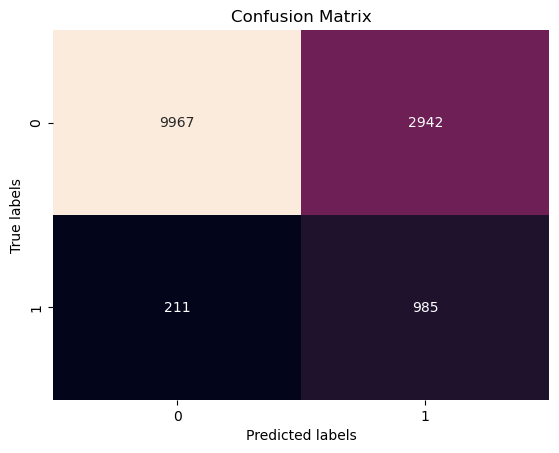

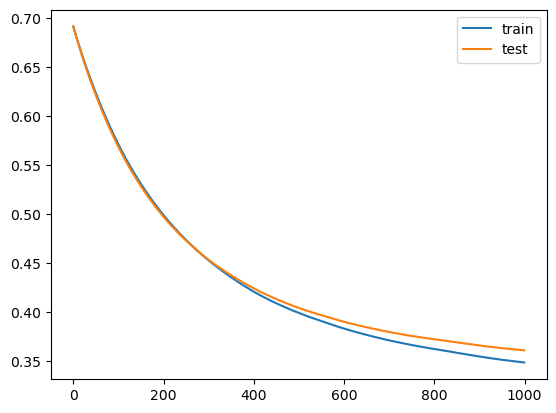

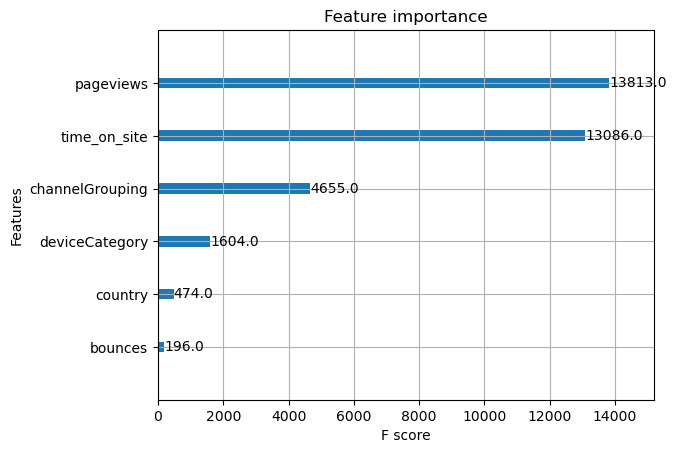

Successfully registered model 'xgboost_model'.
2023/01/15 16:56:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost_model, version 1
Created version '1' of model 'xgboost_model'.


In [248]:
params_xgboost = {'alpha': 1e-05,
                  'gamma': 0.2,
                  'learning_rate': 0.003,
                  'max_depth': 6,
                  'n_estimators': 1000,
                  'random_state': 42
                 }

evalset = [(df_resample_X, df_resample_y),(X_test,y_test)]

try:
    existing_exp = mlflow.get_experiment_by_name('Training_experiment')
    id_exp = existing_exp.experiment_id
except:
    id_exp = mlflow.create_experiment(name = "Training_experiment")
    
    
with mlflow.start_run(experiment_id=id_exp,run_name="XGBoost_best_param_2"):
        xgb = XGBClassifier(**params_xgboost)
        xgb.fit(df_resample_X, df_resample_y,eval_set=evalset)

        predicted = xgb.predict(X_test)

        acc,prec,rec,f1 = eval_metrics(y_test, predicted)

        print("  Accuracy: %s" % acc)
        print("  Precision: %s" % prec)
        print("  Recall: %s" % rec)
        print("  F1 score: %s" % f1)

        #mlflow.log_param("criterion", rfc.criterion)
        #mlflow.log_param("N estimator", rfc.get_params()["n_estimators"])
        mlflow.log_params(xgb.get_params())
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Precision", prec)
        mlflow.log_metric("Recall", rec)
        mlflow.log_metric("F1 score", f1)
        
        ax = plt.subplot()
        sns.heatmap(confusion_matrix(y_test,predicted),annot=True,cbar=False,fmt="g")
        plt.title("Confusion Matrix")
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.show()
        
        plt.plot(xgb.evals_result_['validation_0']['logloss'], label='train')
        plt.plot(xgb.evals_result_['validation_1']['logloss'], label='test')
        # show the legend
        plt.legend()
        # show the plot
        plt.savefig("lc.png")
        mlflow.log_artifact("lc.png")
        plt.show()
        
        plot_importance(xgb)
        plt.savefig("feature_importance.png")
        mlflow.log_artifact("feature_importance.png")
        plt.show()
        


        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
            mlflow.xgboost.log_model(xgb, "model_xgboost", registered_model_name="model",model_format="booster")
        else:
            mlflow.xgboost.log_model(xgb, "model_xgboost",registered_model_name="xgboost_model",model_format="booster")
        mlflow.end_run()

In [163]:
def test_precision(y_true,y_predict,description, viz = True):
  """Function to calculate the recall and precision score for a classes"""
  if viz == True:
    sns.heatmap(confusion_matrix(y_true,y_predict),annot= True, cbar=False)
    plt.title(description)
    print('Precision score : '+ str(precision_score(y_true,y_predict)))
    print('Recall_score : '+str(recall_score(y_true,y_predict)))
    
  precision = precision_score(y_true,y_predict)
  recall = recall_score(y_true,y_predict)
  
  return precision, recall 

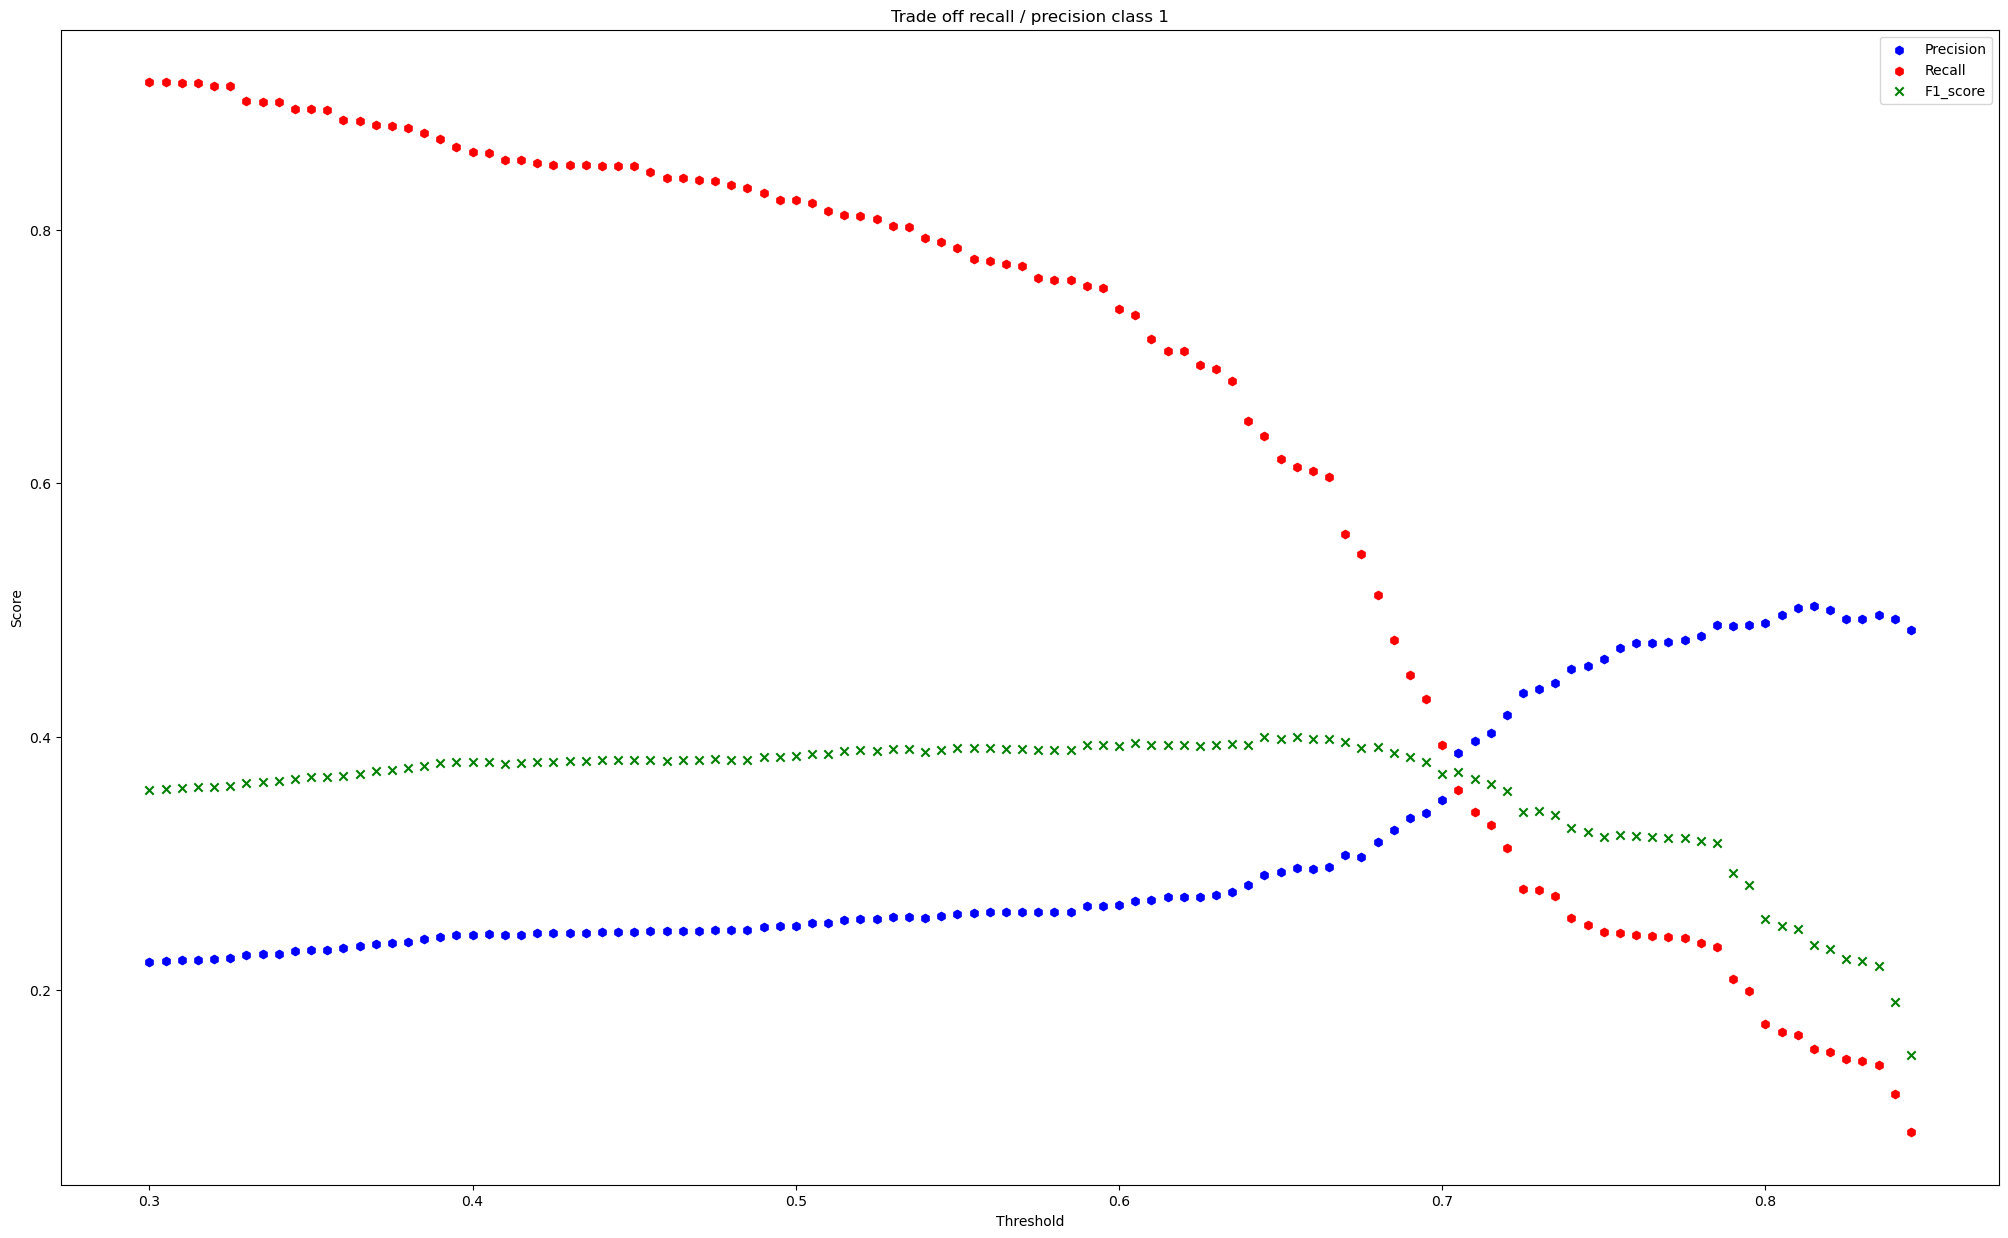

In [192]:
# #Just one time
X_test_df = X_test.copy()
X_test_df["proba_1"] = xgb.predict_proba(X_test)[:,1]
X_test_df["true"] = y_test

thresholding_list = np.arange(0.30,0.85,0.005)
threshold_df = []

pre_1 = []
recall_1 = []
F1_score = []

try: 
    
    existing_exp = mlflow.get_experiment_by_name('Threshold_moving')
    id_exp_threshold = existing_exp.experiment_id
except:
    id_exp_threshold = mlflow.create_experiment('Threshold_moving')

for i in thresholding_list :
    
    with mlflow.start_run(experiment_id=id_exp_threshold,run_name=f"Thresholding_testing_XGBOOST_{str(round(i,3))}"):
        threshold_df.append(i)
        predicted_value= X_test_df["proba_1"].apply(lambda x : 1 if x >= i else 0)
        actual_value = X_test_df["true"]
        precision,recall = test_precision(actual_value,predicted_value,"Threshold = "+str(i),False)
        F1_ = f1_score(actual_value,predicted_value)
        acc = accuracy_score(actual_value,predicted_value)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1 score", F1_)
        mlflow.log_metric('Threshold',round(i,3))
        pre_1.append(precision)
        recall_1.append(recall)
        F1_score.append(F1_)
        dico_df = {"Threshold":threshold_df,
              "Recall":recall_1,
              "Precision":pre_1,
              "F1_score": F1_score}
        RF_preci_recall= pd.DataFrame(dico_df)
        mlflow.end_run()
                          
with mlflow.start_run(experiment_id=id_exp_threshold,run_name="General_experiment_review_Threshold_moving"):
    plt.figure(figsize = (25,15))
    plt.scatter(RF_preci_recall.Threshold, RF_preci_recall['Precision'], marker='h', color='blue', label='Precision')
    plt.scatter(RF_preci_recall.Threshold, RF_preci_recall['Recall'], marker='h', color='red', label='Recall')
    plt.scatter(RF_preci_recall.Threshold, RF_preci_recall['F1_score'], marker='x', color='green', label='F1_score')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title("Trade off recall / precision class 1") 
    plt.savefig("Threshold_moving.png")
    mlflow.log_artifact("Threshold_moving.png")
    plt.show()
    Best_F1 = RF_preci_recall['F1_score'].max()
    Best_Recall = RF_preci_recall['Recall'].max()
    Best_Precision = RF_preci_recall['Precision'].max()
    mlflow.log_metric("Best Precision", Best_Precision)
    mlflow.log_metric("Best Recall", Best_Recall)
    mlflow.log_metric("Best F1 score", Best_F1)
                          
    RF_preci_recall.to_csv("Precision_recall_trade_off.csv",header=True)
    mlflow.log_artifact('Precision_recall_trade_off.csv')
    
    mlflow.end_run()

In [190]:
RF_preci_recall.sort_values('F1_score',ascending=False)

,Threshold,Recall,Precision,F1_score
49,0.645,0.637124,0.290951,0.399476
51,0.655,0.612876,0.296162,0.399346
52,0.660,0.609532,0.295860,0.398361
53,0.665,0.604515,0.296920,0.398237
50,0.650,0.618729,0.293534,0.398171
...,...,...,...,...
85,0.825,0.145485,0.492918,0.224661
86,0.830,0.143813,0.492837,0.222654
87,0.835,0.140468,0.495575,0.218893
88,0.840,0.117893,0.493007,0.190283


Text(0.5, 1.0, 'Trade off recall / precision class 1')

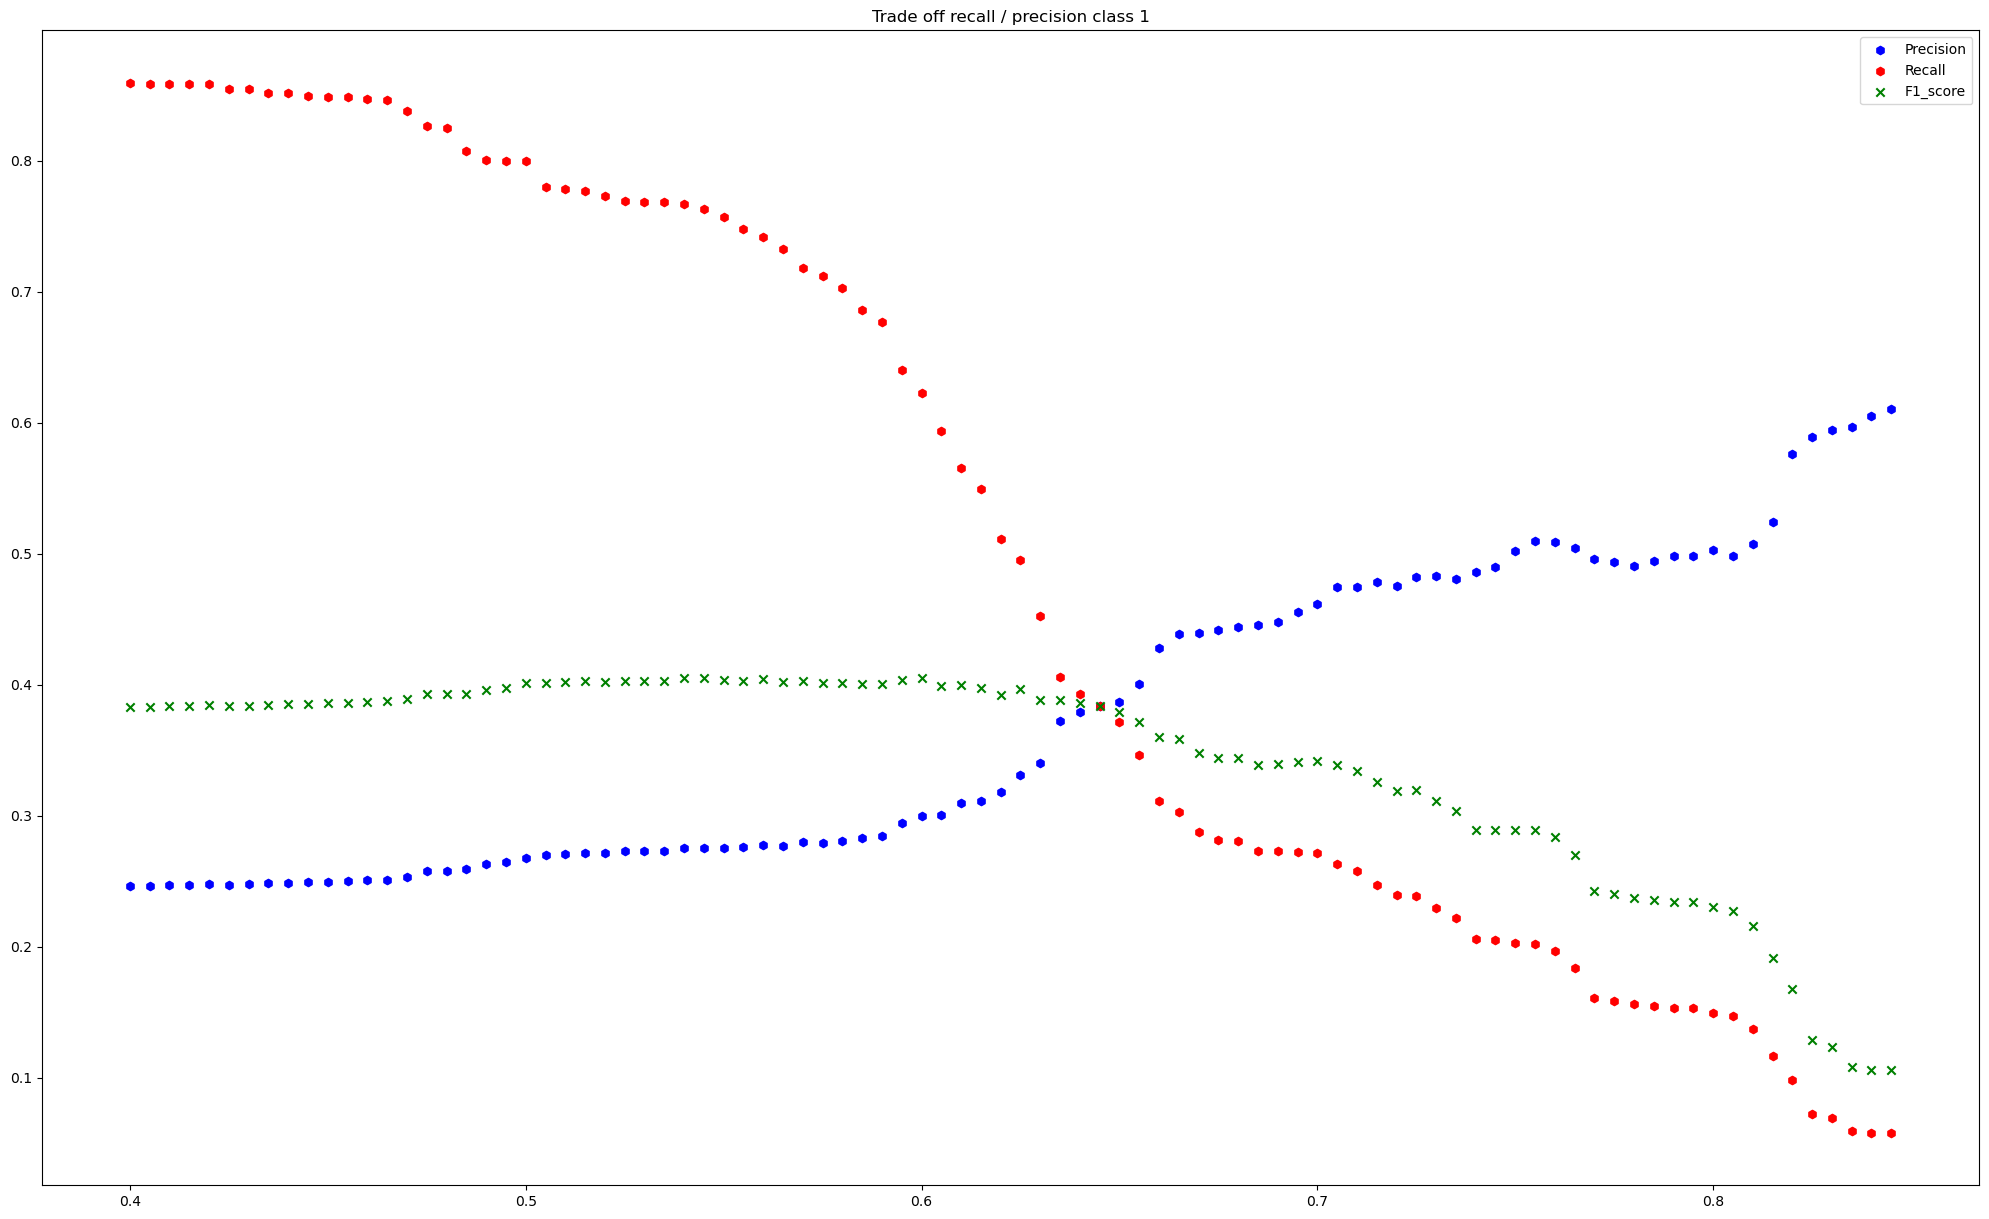

In [402]:
plt.figure(figsize = (25,15))
plt.scatter(RF_preci_recall.Threshold, RF_preci_recall['Precision'], marker='h', color='blue', label='Precision')
plt.scatter(RF_preci_recall.Threshold, RF_preci_recall['Recall'], marker='h', color='red', label='Recall')
plt.scatter(RF_preci_recall.Threshold, RF_preci_recall['F1_score'], marker='x', color='green', label='F1_score')
plt.legend()
plt.title("Trade off recall / precision class 1")

Dans le cadre des dataset déséquilibré la méthode du t m a pu amélioré des résultats. Dans notre cas, il ne semble pas avoir un impact décisif. Je perds trop de **Recall** par rapport au gain du **f1_score** et de **Precision**.  
Nous cherchons à augmenter la Precision mais sans trop pénaliser le Recall.  
Le point de croisement optimal semble être **0.6 de theshold** qui augmente légèrement la Precision sans pour autant totalement baisser le Recall.  

## Feature Importance

In [396]:
xgb.feature_importances_

array([0.02567015, 0.05462267, 0.69124687, 0.08899647, 0.08343233,
       0.05603142], dtype=float32)

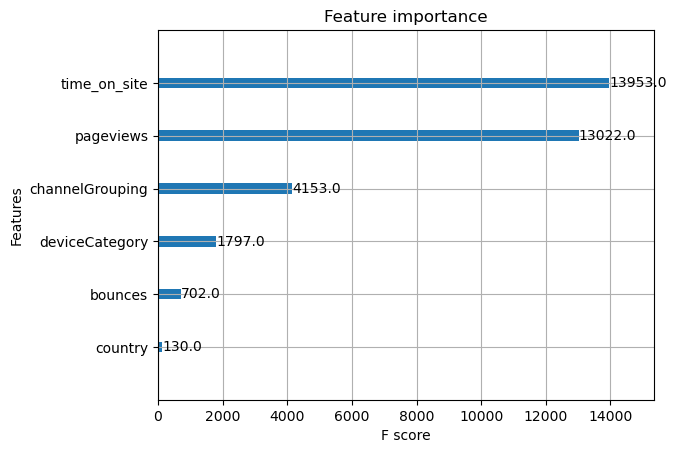

In [399]:
plot_importance(loaded_model)
plt.show()

Vue le peu d'importance que possède country, il faudra finalement drop la colonne et réentraîner le modèle sans celle-ci.

## Save model

In [ ]:
# import pickle

# with open("model.pkl", "wb") as file:
#     pickle.dump(model, file)